# Steam Review Data Mining Project

## Kacper Lewtak

# 1 A Recommender System for Video Games, Based on Steam Reviews

Over the past two decades, the video games industry has grown from being a niche market to now being an industry worth hundreds of billions of dollars. One of the cornerstones of this industry is an online games platform called Steam, which enjoys the daily traffic and use by millions of people. Behaving as a discussion board, social network, and, most relevant to this project, a storefront. From its inception in 2003, Steam has uniquely positioned itself to be *the* place to go to for all things video games.

An important aspect of the storefront is the recommendations system, which is the primary interest of this project. This system has long been criticized by users for either being inadequate or seldomly correct. As such, this project showcases some possible recommenders created using the Steam Reviews dataset.  

## 1.1 Executive Summary


This project seeks to create a recommender system using the review data collected from the Steam storefront. This data is current to the year 2024 and contains entries from as far back as 2010. The primary benefit of this system would be to accurately provide game recommendations based on a variety of factors. Accurate recommendations can lead to improved game sales with secondary benefits including customer retention, customer satisfaction, and platform growth.

Appropriate steps were taken to reduce and transform necessary data, before creating condensed representations, "ratings", of the various variables that would later be used in the recommender systems.

Throughout this project I found that despite the abundance of the data, the two proposed methods of creating a recommender system, Collaborative Filtering with SVD and Graph Based recommenders, are not sufficient in their current state. The foremost reason for their lack of quality can be rooted to an overwhelming amount of positive reviews for niche games, resulting in many games with a near perfect 100% upvote rating. In reality, we would not want to recommend such games to everyone and therefore steps were taken to remediate this issue. Additionally, the sheer quanitity of information present in this dataset made it difficult to assign a meaningful "rating" value to any particular review.

The written portion of the reviews were ignored for this project in order to contain scope, but it would be recommended that future endeavors attempt to include that information as it is highly informative.

All told, this project showcases the challenges of creating recommender systems from large scale datasets.

## 1.2 Data Import

To begin with, we pull the data directly from the Kaggle website so as to reduce the necessity to upload to my own drive. We also setup the colab environment to run with hardware accelerated pandas so as to expedite processing.

In [ ]:
!pip install surprise
from surprise import accuracy, SVD, Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
import pandas as pd

# Importing necessary libraries
import time
import math
import random
random.seed(108)


import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from networkx.algorithms import bipartite
import keras
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# pickle the csv file and export
def save_pickle(file_dir, file):
    with open(file_dir, 'wb') as f:
        pickle.dump(file, f)

save_pickle('/content/scaled_data_aggregate.pkl', df)

!cp /content/scaled_data_aggregate.pkl "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data"

In [ ]:
# mount drive if not mounted already
# from google.colab import drive
# drive.mount('/content/drive')

# copy the csv files to the drive
# !cp /content/weighted_score_above_08.csv "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data"
# !cp /content/preprocessed_reviews.csv "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data"

# copy csv files from drive to colab disk
# !cp "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data/weighted_score_above_08.csv" /content/
# !cp "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data/processed_reviews2021.pkl" /content/
!cp "/content/drive/MyDrive/Colab Notebooks/CSCI E-108/data/scaled_data_aggregate.pkl" /content/

In [ ]:
def load_pickle(file_dir):
    with open(file_dir, 'rb') as f:
        opened_pickle = pickle.load(f)

    return opened_pickle

df = load_pickle('/content/scaled_data_aggregate.pkl')

In [ ]:
!pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kieranpoc/steam-reviews

Dataset URL: https://www.kaggle.com/datasets/kieranpoc/steam-reviews
License(s): MIT
100% 16.1G/16.1G [14:24<00:00, 21.7MB/s]
100% 16.1G/16.1G [14:24<00:00, 19.9MB/s]


In [ ]:
!unzip steam-reviews.zip

Archive:  steam-reviews.zip
  inflating: all_reviews/all_reviews.csv  
  inflating: weighted_score_above_08.csv  


## 1.3 Data Overview

This dataset is composed of 24 columns spanning 113,883,717 rows (\~41.5GB). This of course is too large of a dataset to consider for this project all at once and, therefore, I will only focus on reviews made in English, which accounts for 51,544,612 (\~18.4GB) total rows.

Description of data:

---

Variable name      | Description      | Data Type
-------------------|------------------|---------------
recommendationid   | This is the numeric ID of the review itself. Unique per review.                               | INT
appid              | This is the numeric ID of the game being reviewed. Unique for each game in Steam's database.    | INT
game               | Title of the game | STRING
author_steamid     | The is the numeric ID of the individual writing the review.                               | INT
author_num_games_owned | The number of games owned by the author of the review.                               | INT
author_num_reviews | The number of reviews written by the author.                               | INT
author_playtime_forever | The total amount of time, in hours, that the author has played the game they are reviewing. | INT
author_playtime_last_two_weeks | The total amount of time, in hours, that the author has played the game over the past two weeks. | INT
author_playtime_at_review | The total amount of time, in hours, that the author has played at the time of the review. | INT
author_last_played | The date, in UNIX time, that the author last played the game being reviewed.                  | INT
language           | The language in which the review is written.                              | STRING
review             | Written feedback from the user. | OBJECT
timestamp_created  | Date and time which the review was published.                            | INT
timestamp_updated  | Date and time which the review may have been updated.                              | INT
voted_up           | This categorizes whether the review left is positive, voted up, or negeative, voted down.   | BOOLEAN
votes_up           | Total number of votes from the community. Usually an indication that another person has found the review useful. | INT
votes_funny        | Votes representing that the review is humorous or sarcastic in nature.                  | INT
weighted_vote_score | An automatically calculated vote score which Steam calculates on its own. Indicates the helpfullness of the review. | FLOAT
comment_count      | Total number of comments that a particular review recieved from others.                          | INT
steam_purchase     | Indicates whether or not the user purchased the game on Steam. Can indicate that a game license was purchased elsewhere. | BOOLEAN
recieved_for_free  | Indicates whether or not the user recieved the game for free.                                 | BOOLEAN
written_during_early_access | Indicates whether or not the review was made during an early access phase of a game's release. | BOOLEAN
hidden_in_steam_china | Indicates whether or not the review is flagged as hidden for users of Steam in China.   | BOOLEAN
steam_china_location | Indicates the location of the user in China, if they have set it as their country of origin. | NULL

---

As we can see from this chart, this is a comprehensive dataset with a wide variety of attributes which can be used to create a recommender system. This overview also shows that certain methods, such as K-Means clustering, might not be effective for this particular dataset given the high dimensionality.

# 2 Exploratory Data Analysis (EDA)

Here I present the findings of the Steam Reviews dataset.

The dataset presented consists of approximately 51 million reviews from English speaking regions. There are some NaN values which have been dropped, and all other values have been converted into appropriate datatypes.

Given the abundance of data, a further reduction step is taken to only consider reviews written after January 1st, 2021. This step effectively reduces the number of reviews by half making memory management more feasible. Additionally, several columns can be dropped, such as steam_china_location and hidden_in_steam_china as this project primarily focuses on the U.S. audience. I took great efforts to reduce the dataset given the limited resources that I have to work with.

The below sections detail the steps taken to inspect and understand the corpus of data.

## 2.1 Data Preparation

### Initial Preprocessing and Slimming Down the Dataset

Here we trim the dataset to better suit our interests. Given that this is a massive collection of reviews spanning multiple languages, we are going to focus our efforts on the English reviews. The rest of the reviews will be dropped from the dataset.

In [ ]:
%%time
# Creating the pre-processed dataframe

# 1. Loading the data in chunks from the csv, given large file size
chunksize = 10**6 # one million rows per chunk, given 113 million rows of total data
filename = '/content/all_reviews/all_reviews.csv'

# 2. For each chunk in the csv, we want to only save rows which have the value 'english' in the language column
df = pd.DataFrame()
for chunk in pd.read_csv(filename, chunksize=chunksize):
    df = pd.concat([df, chunk[chunk['language'] == 'english']])

# 3. Printing the head and shape of the dataframe
print(df.head())
print(df.shape)

# 4. Saving the dataframe as a preprocessed csv
df.to_csv('preprocessed_reviews.csv', index=False)

/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  re

    recommendationid  appid            game     author_steamid  \
4          148912575     10  Counter-Strike  76561198363716821   
10         148895540     10  Counter-Strike  76561198134752176   
11         148895230     10  Counter-Strike  76561197985437504   
25         148865538     10  Counter-Strike  76561199015747395   
28         148862089     10  Counter-Strike  76561199479067349   

    author_num_games_owned  author_num_reviews  author_playtime_forever  \
4                        0                   2                    197.0   
10                      69                   1                  12107.0   
11                       0                   5                  42519.0   
25                      71                  34                     30.0   
28                       5                   6                    209.0   

    author_playtime_last_two_weeks  author_playtime_at_review  \
4                             41.0                        197   
10                    

In [ ]:
df = pd.read_csv('preprocessed_reviews.csv')

<ipython-input-3-46e1df374f5f>:1: DtypeWarning: Columns (0,2,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('preprocessed_reviews.csv')


The above warning that certain columns have mixed types is our first indicator that we need to more deeply explore what is happening there.

### Viewing the initial DataFrame

In [ ]:
df.head()

recommendationid  appid            game  author_steamid  \
0        148912575   10.0  Counter-Strike    7.656120e+16   
1        148895540   10.0  Counter-Strike    7.656120e+16   
2        148895230   10.0  Counter-Strike    7.656120e+16   
3        148865538   10.0  Counter-Strike    7.656120e+16   
4        148862089   10.0  Counter-Strike    7.656120e+16   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                     0.0                 2.0                    197.0   
1                    69.0                 1.0                  12107.0   
2                     0.0                 5.0                  42519.0   
3                    71.0                34.0                     30.0   
4                     5.0                 6.0                    209.0   

   author_playtime_last_two_weeks  author_playtime_at_review  \
0                            41.0                      197.0   
1                             0.0                    12107.0   
2                             3.0                    42515.0   
3                             0.0                       30.0   
4                           200.0                      209.0   

   author_last_played  ... voted_up votes_up  votes_funny  \
0        1.698329e+09  ...      1.0      0.0          0.0   
1        1.670488e+09  ...      1.0      0.0          0.0   
2        1.698306e+09  ...      1.0      0.0          0.0   
3        1.639628e+09  ...      1.0      0.0          0.0   
4        1.697758e+09  ...      1.0      1.0          0.0   

   weighted_vote_score  comment_count  steam_purchase  received_for_free  \
0              0.00000            0.0             1.0                0.0   
1              0.00000            0.0             0.0                0.0   
2              0.00000            0.0             0.0                0.0   
3              0.00000            0.0             1.0                0.0   
4              0.52381            0.0             1.0                0.0   

   written_during_early_access  hidden_in_steam_china  steam_china_location  
0                          0.0                    1.0                   NaN  
1                          0.0                    1.0                   NaN  
2                          0.0                    1.0                   NaN  
3                          0.0                    1.0                   NaN  
4                          0.0                    1.0                   NaN  

[5 rows x 24 columns]

In [ ]:
df.nunique()

recommendationid                  51352825
appid                                97266
game                                 96654
author_steamid                    13087265
author_num_games_owned                8246
author_num_reviews                    1040
author_playtime_forever             449113
author_playtime_last_two_weeks       19015
author_playtime_at_review           299325
author_last_played                38405010
language                                 3
review                            39475091
timestamp_created                 44982266
timestamp_updated                 44716458
voted_up                                 2
votes_up                              3628
votes_funny                           2635
weighted_vote_score                4038745
comment_count                          411
steam_purchase                           2
received_for_free                        2
written_during_early_access              2
hidden_in_steam_china                    2
steam_china

In [ ]:
# check dataframe for any NaN values
df.isna().sum()

recommendationid                         0
appid                              6848512
game                               6850291
author_steamid                     6848512
author_num_games_owned             6848512
author_num_reviews                 6848512
author_playtime_forever            6848514
author_playtime_last_two_weeks     6848514
author_playtime_at_review          6848512
author_last_played                 6848514
language                           6848512
review                             6882121
timestamp_created                  9956988
timestamp_updated                  9956988
voted_up                           9956988
votes_up                           9956988
votes_funny                        9956988
weighted_vote_score                9956988
comment_count                      9956988
steam_purchase                     9956988
received_for_free                  9956988
written_during_early_access        9956988
hidden_in_steam_china              9956988
steam_china

#### Cleaning NaN Entries

The last column, steam_china_location, appears to be a blank column with all NaN values. As such, we will drop that column from the dataset. Likewise, we will want to drop any rows, with the exception of reviews, which have NaN values. For rows in which only the reviews have NaN values, we will replace them with blank entries.

In [ ]:
# Replacing the NaN reviews with a blank character
df['review'] = df['review'].fillna('')

# Dropping the last column in the df
# Removing any remaining rows which have NaN values
df = df.iloc[:, :-1].dropna()

In [ ]:
# Checking for any NaN values we might have missed
pd.set_option('display.max_columns', None)
df[df.isna().any(axis=1)].head()

Empty DataFrame
Columns: [recommendationid, appid, game, author_steamid, author_num_games_owned, author_num_reviews, author_playtime_forever, author_playtime_last_two_weeks, author_playtime_at_review, author_last_played, language, review, timestamp_created, timestamp_updated, voted_up, votes_up, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, hidden_in_steam_china]
Index: []

#### Changing Data Types

Notice that there are many columns which are stored as float64 datatypes. This seems excessive given that we expect most entries in the file to be a simple integer type. Here we check to see which columns need to be Floats and which can be safely converted to Ints, saving space.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51542675 entries, 0 to 51542674
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   recommendationid                int64  
 1   appid                           float64
 2   game                            object 
 3   author_steamid                  float64
 4   author_num_games_owned          float64
 5   author_num_reviews              float64
 6   author_playtime_forever         float64
 7   author_playtime_last_two_weeks  float64
 8   author_playtime_at_review       float64
 9   author_last_played              float64
 10  language                        object 
 11  review                          object 
 12  timestamp_created               float64
 13  timestamp_updated               float64
 14  voted_up                        float64
 15  votes_up                        float64
 16  votes_funny                     float64
 17  weighted_vote_score      

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
df.describe()

recommendationid    appid    author_steamid  author_num_games_owned  \
count          51542675 51542675          51542675                51542675   
mean           80192363   617243 76561198347193248                     146   
std            41681694   529381         415123050                     522   
min                  43       10 76561197960265728                       0   
25%            44681043   242680 76561198046919232                       0   
50%            82102259   424370 76561198144763488                       0   
75%           116208200   977950 76561198432832720                     114   
max           149450036  2660040 76561199568418160                   30468   

       author_num_reviews  author_playtime_forever  \
count            51542675                 51542675   
mean                   31                    14671   
std                   217                    47461   
min                     1                        0   
25%                     3                      549   
50%                     7                     2197   
75%                    19                     9105   
max                 10446                  6007985   

       author_playtime_last_two_weeks  author_playtime_at_review  \
count                        51542675                   51542675   
mean                               78                       6938   
std                               583                      26023   
min                                 0                          0   
25%                                 0                        268   
50%                                 0                        912   
75%                                 0                       3530   
max                             56748                    4880175   

       author_last_played  timestamp_created  timestamp_updated  voted_up  \
count            51542675           51542675           51542675  51542675   
mean           1605720911         1587442321         1591406246         1   
std             223932263           85052788           83819334         0   
min                     0         1287181492         1287181492         0   
25%            1598202004         1536664210         1544475885         1   
50%            1662911942         1607715348         1610693794         1   
75%            1690936390         1653850790         1657086150         1   
max            1699061207         1699028185         1699039248         1   

       votes_up  votes_funny  weighted_vote_score  comment_count  \
count  51542675     51542675             51542675       51542675   
mean          2        72080                    0             83   
std          40     17594657                    0         598241   
min           0            0                    0              0   
25%           0            0                    0              0   
50%           0            0                    0              0   
75%           1            0                    0              0   
max       62199   4294967295                    1     4294967295   

       steam_purchase  received_for_free  written_during_early_access  \
count        51542675           51542675                     51542675   
mean                1                  0                            0   
std                 0                  0                            0   
min                 0                  0                            0   
25%                 0                  0                            0   
50%                 1                  0                            0   
75%                 1                  0                            0   
max                 1                  1                            1   

       hidden_in_steam_china  
count               51542675  
mean                       0  
std                        0  
min                        0  
25%                        0  
50%                        0  
75%                   

Here we want to condense down the values into datatypes which make sense. Not all of the columns need to be of type float64, but we do have some very large numbers which will not fit into a regular int. As such, we keep columns which have decimal values as float64, small number columns into an int32, and large number columns into int64. Likewise, columns which only consist of 0 or 1 will be converted to a boolean.

In [ ]:
# Getting each column that is of type float64
for col in df.select_dtypes(include=['float64']).columns:
    col_values = df[col].values

    # Checking to make sure that the column values are actual floats
    if np.all(col_values % 1 == 0):
        max_val = col_values.max()
        if max_val == 1 and np.min(col_values) == 0:
            df[col] = df[col].astype(bool)
        elif max_val <= np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51542675 entries, 0 to 51542674
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   recommendationid                int64  
 1   appid                           int32  
 2   game                            object 
 3   author_steamid                  int64  
 4   author_num_games_owned          int32  
 5   author_num_reviews              int32  
 6   author_playtime_forever         int32  
 7   author_playtime_last_two_weeks  int32  
 8   author_playtime_at_review       int32  
 9   author_last_played              int32  
 10  language                        object 
 11  review                          object 
 12  timestamp_created               int32  
 13  timestamp_updated               int32  
 14  voted_up                        bool   
 15  votes_up                        int32  
 16  votes_funny                     int64  
 17  weighted_vote_score      

In [ ]:
df.shape

(51542675, 23)

#### Inspecting the Object columns

There remain 4 columns of type Object which we need to explore and understand. We expect that the 'review' column will have mixed data values (text, numbers, symbols, etc.) and therefore expect the object dataype. The other columns are somewhat suspect.

In [ ]:
# Checking the 4 object datatype columns for values inside. If there is only text,
# want to then convert that column to string
for col in df.select_dtypes(include=['object']).columns:
    col_values = df[col].values  # Convert pandas Series to NumPy array
    unique_types = set(type(x) for x in col_values)
    if len(unique_types) > 1:
        print(f"Column '{col}' contains mixed types.")
    else:
        # Check if the column contains only text
        if all(isinstance(x, str) for x in col_values):
            df[col] = df[col].astype('string')

Column 'review' contains mixed types.


In [ ]:
# Cutting off data and keeping reviews made after 2020
df = df[df['timestamp_created'] > 1609477200]
df.shape

(25144646, 23)

In [ ]:
df.head()

recommendationid  appid            game     author_steamid  \
0         148912575     10  Counter-Strike  76561198363716816   
1         148895540     10  Counter-Strike  76561198134752176   
2         148895230     10  Counter-Strike  76561197985437504   
3         148865538     10  Counter-Strike  76561199015747392   
4         148862089     10  Counter-Strike  76561199479067344   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                       0                   2                      197   
1                      69                   1                    12107   
2                       0                   5                    42519   
3                      71                  34                       30   
4                       5                   6                      209   

   author_playtime_last_two_weeks  author_playtime_at_review  \
0                              41                        197   
1                               0                      12107   
2                               3                      42515   
3                               0                         30   
4                             200                        209   

   author_last_played  ... timestamp_updated voted_up  votes_up  votes_funny  \
0          1698329401  ...        1698329419     True         0            0   
1          1670487891  ...        1698306096     True         0            0   
2          1698305811  ...        1698305569     True         0            0   
3          1639627518  ...        1698257515     True         0            0   
4          1697757761  ...        1698253394     True         1            0   

   weighted_vote_score  comment_count  steam_purchase  received_for_free  \
0              0.00000              0            True              False   
1              0.00000              0           False              False   
2              0.00000              0           False              False   
3              0.00000              0            True              False   
4              0.52381              0            True              False   

   written_during_early_access  hidden_in_steam_china  
0                        False                   True  
1                        False                   True  
2                        False                   True  
3                        False                   True  
4                        False                   True  

[5 rows x 23 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25144646 entries, 0 to 51542658
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   recommendationid                int64  
 1   appid                           int32  
 2   game                            string 
 3   author_steamid                  int64  
 4   author_num_games_owned          int32  
 5   author_num_reviews              int32  
 6   author_playtime_forever         int32  
 7   author_playtime_last_two_weeks  int32  
 8   author_playtime_at_review       int32  
 9   author_last_played              int32  
 10  language                        string 
 11  review                          object 
 12  timestamp_created               int32  
 13  timestamp_updated               int32  
 14  voted_up                        bool   
 15  votes_up                        int32  
 16  votes_funny                     int64  
 17  weighted_vote_score           

In [ ]:
df.nunique()

recommendationid                  25069587
appid                                82761
game                                 82358
author_steamid                     8673726
author_num_games_owned                7041
author_num_reviews                     968
author_playtime_forever             302274
author_playtime_last_two_weeks       18206
author_playtime_at_review           229046
author_last_played                18517742
language                                 1
review                            18570516
timestamp_created                 21495844
timestamp_updated                 21472261
voted_up                                 2
votes_up                              2694
votes_funny                           1362
weighted_vote_score                1809172
comment_count                          269
steam_purchase                           2
received_for_free                        2
written_during_early_access              2
hidden_in_steam_china                    2
dtype: int6

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
df.describe()

recommendationid        appid        author_steamid  \
count      25144646.000 25144646.000          25144646.000   
mean      116945342.589   859009.582 76561198509304800.000   
std        18890151.807   595088.802         476323612.448   
min        83703110.000       10.000 76561197960265744.000   
25%       100687518.500   335300.000 76561198076025712.000   
50%       116963727.500   782330.000 76561198306788128.000   
75%       133468107.000  1258320.000 76561199015826832.000   
max       149450036.000  2660040.000 76561199568418160.000   

       author_num_games_owned  author_num_reviews  author_playtime_forever  \
count            25144646.000        25144646.000             25144646.000   
mean                  112.150              29.569                10978.794   
std                   441.244             241.150                36705.744   
min                     0.000               1.000                    0.000   
25%                     0.000               3.000                  577.000   
50%                     0.000               7.000                 2069.000   
75%                    78.000              18.000                 7359.000   
max                 30468.000           10446.000              5887267.000   

       author_playtime_last_two_weeks  author_playtime_at_review  \
count                    25144646.000               25144646.000   
mean                          115.407                   6045.341   
std                           734.110                  25442.048   
min                             0.000                      0.000   
25%                             0.000                    274.000   
50%                             0.000                    860.000   
75%                             0.000                   3071.000   
max                         56748.000                4880175.000   

       author_last_played  timestamp_created  timestamp_updated     votes_up  \
count        25144646.000       25144646.000       25144646.000 25144646.000   
mean       1645840822.119     1655031908.175     1656094929.592        2.164   
std         213959646.569       25757672.105       25768950.086       38.576   
min                 0.000     1609477202.000     1609477202.000        0.000   
25%        1656888316.000     1633630258.000     1635025272.500        0.000   
50%        1682769511.000     1655197933.000     1656773937.500        0.000   
75%        1694979861.000     1677215083.000     1678318332.500        1.000   
max        1699031117.000     1699028185.000     1699028185.000    62199.000   

       votes_funny  weighted_vote_score  comment_count  
count 25144646.000         25144646.000   25144646.000  
mean         0.535                0.159        170.874  
std         13.419                0.242     856519.191  
min          0.000                0.000          0.000  
25%          0.000                0.000          0.000  
50%          0.000                0.000          0.000  
75%          0.000                0.476          0.000  
max      24987.000                0.992 4294967295.000

The data has now been successfully processed. We reduced the overall file size, handled NaN values, corrected datatypes, and removed columns which did not contain any information.

## 2.2 Data Exploration

We can now begin to look into the behaviors of the reduced dataset.

For this project I choose to particularly focus on several features which I believe, from experience, will be key interaction terms. The goal is to not only classify whether a user enjoyed a game, but to also to quanitify the degree to which they enjoyed their experience.

This will be done through the following features:

'author_playtime_last_two_weeks', 'author_playtime_at_review', 'votes_up', 'voted_up', 'votes_funny', 'weighted_vote_score', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'comment_count','author_num_games_owned', 'author_num_reviews'

These are all features which indicate some level of interaction with the game. Some are boolean types, such as: did a user recieved a game for free, which might lead to a psychological bias in the review. The inclusion time played at the time of the review are important for understanding if a review might have been written before an individual has had the opportunity to play through the entire game. The addition of time played over the past two weeks can be seen as a supporting indication that the game continues to be enjoyed.

### 2.2.1 Univariate Exploration

**Data Distributions**

I start with univariate exploration to gain a better understanding of how each feature within the dataset behaves and is distributed. This is done through a KDE plot as well as a series of Violin plots. While these two methods of plotting effectively show the same information, the presentation of both lends itself to a better understanding of what issues are prevalent in the data.

Notably, there are severe skews present in the data, particularly with respect to the variables that we will be using as our interaction terms. This is expected. This is a typical example of zero-inflation, where most of the reviews will have little feedback from the community, in the form of upvotes, votes_funny, and comment count.

There is also a noticeable tail that extends far past zero, indicating the presence of large outliers that will have to be dealt with. Such cases are explored in later sections.


**Distribution of Reviews Per Game & Per User**

We again see zero-inflation come into play here as most games will have only a handful of reviews. These titles are typically indie games that exist either within niche markets or niche customer bases.

Inspecting the top 100 most reviewed games shows that there is a heavy skew even amongst the most popular games. Several factors contribute to this. Firstly, popular games which recieve periodic updates or new additions in the form of Downloadable Content (DLC) often see continued popularity. Given how community centric many games are in the modern market, it is not surprising to see that players congregate to the most popular games in order to play with their peers. Secondly, games which are strictly multiplayer, such as Counter-Strike 2 which has the most reviews, see an outsized player base versus a game which provides a single story to play through. The multiplayer aspect of such games lends itself to reccuring gameplay, which in turn leads to player retention, which in turn leads to more reviews.

The same trends appear when inspecting reviews per user.

**Game Reviews Grouped By Month**

Note that there is an outsized amount of reviews which are posted in January versus all other months in the year. There are several contributing factors to this.

1.   Major titles often release near the winter time. This is strategic to coincide with Black Friday and Christmas sales here in the U.S. Likewise, given the younger age of the target audience, typically 16-22, much of that audience will
2.   Steam typically hosts a large winter sale during the last two weeks of December. I suspect that this is the reason why December has relatively so few game reviews in comparison to January, as users have time to play and leave a review by that time.






Kernel Density Plot

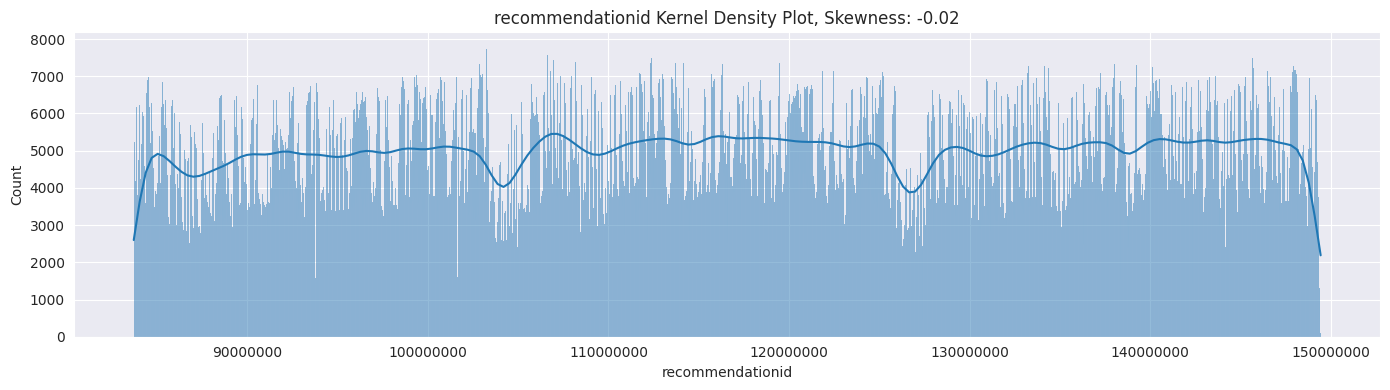

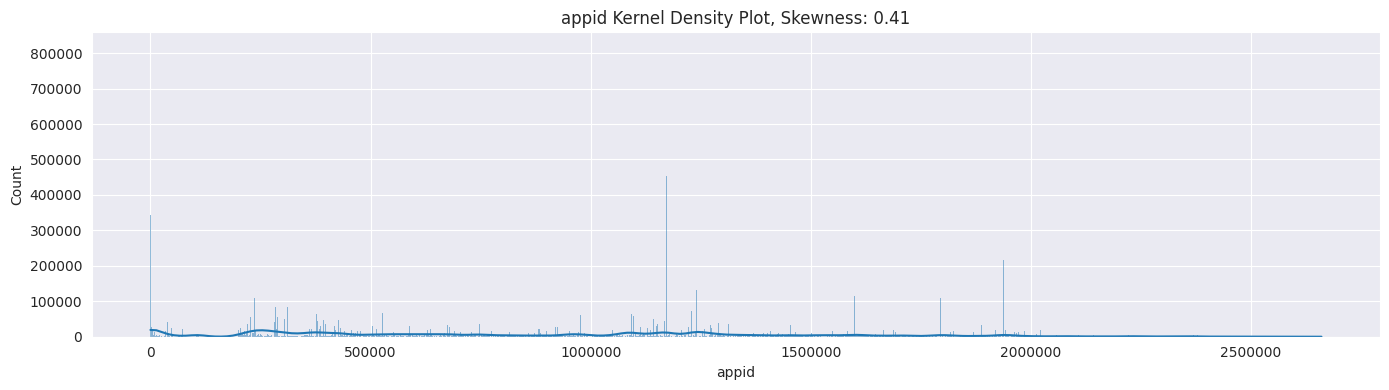

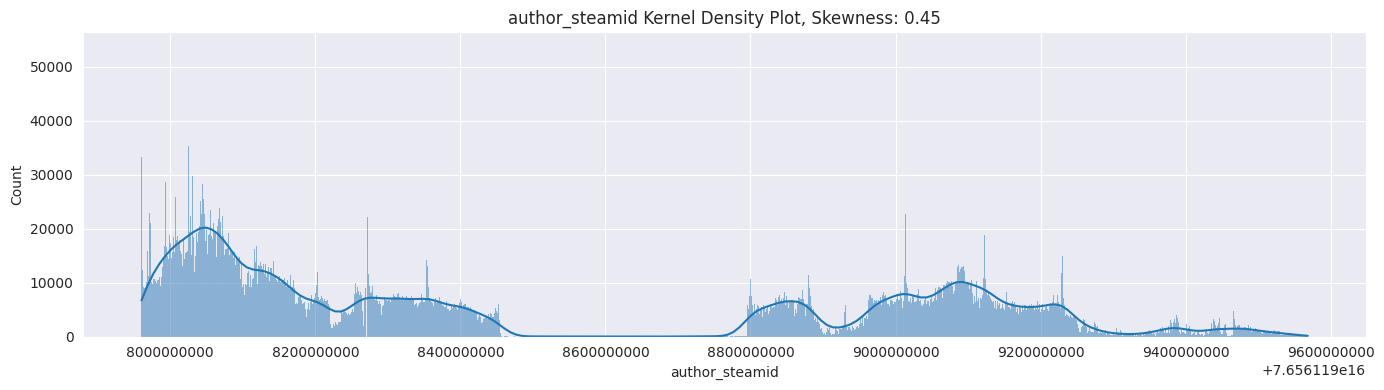

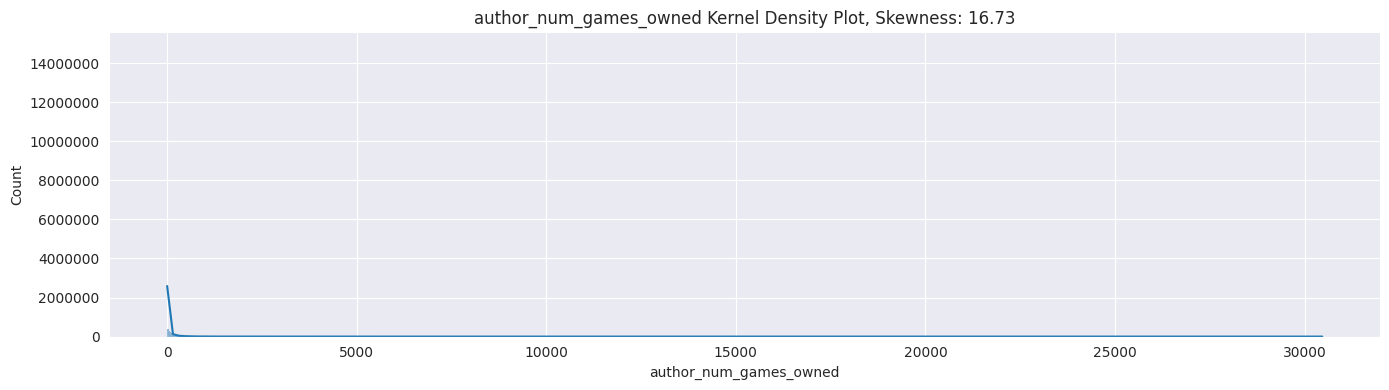

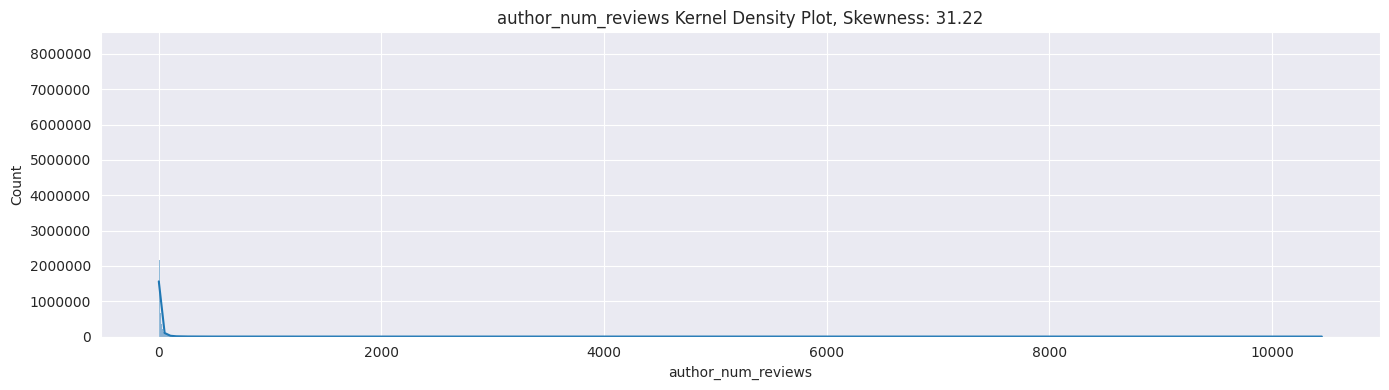

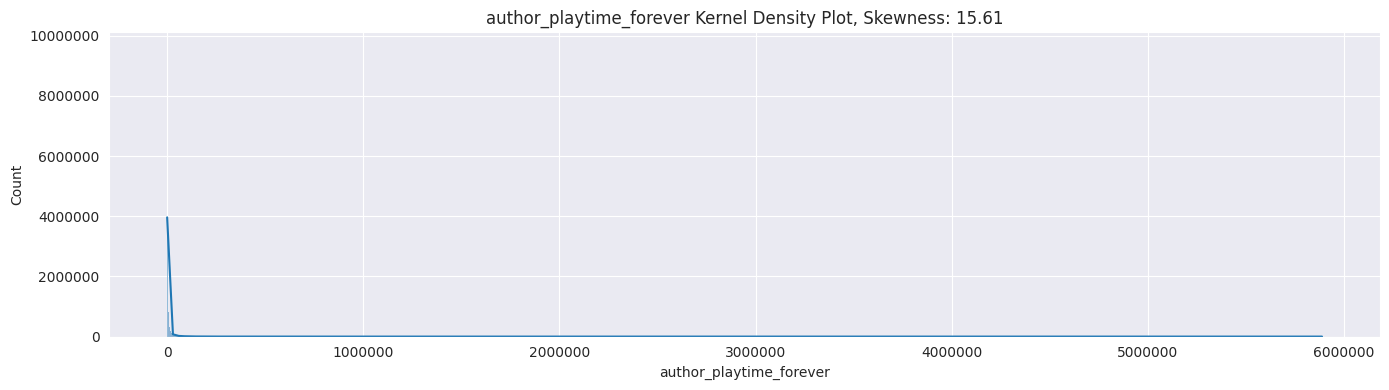

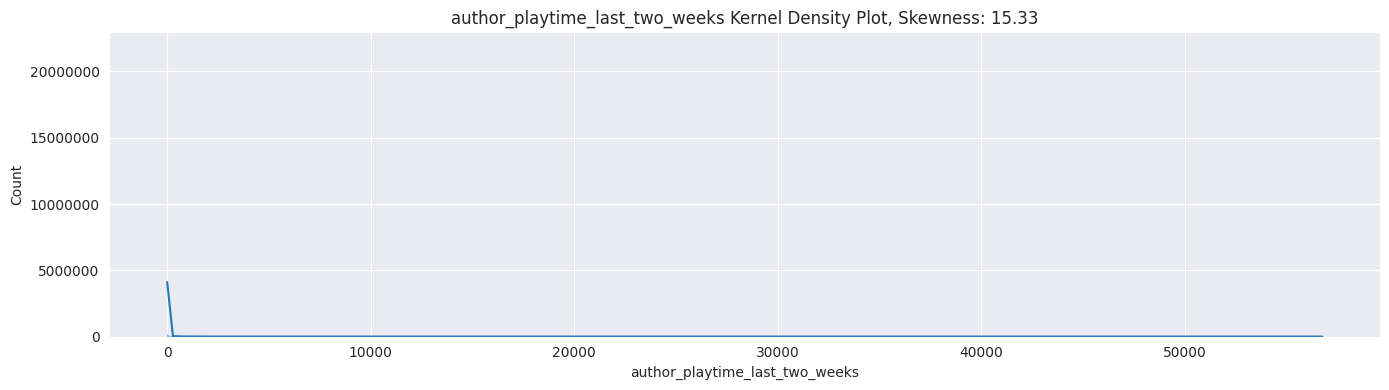

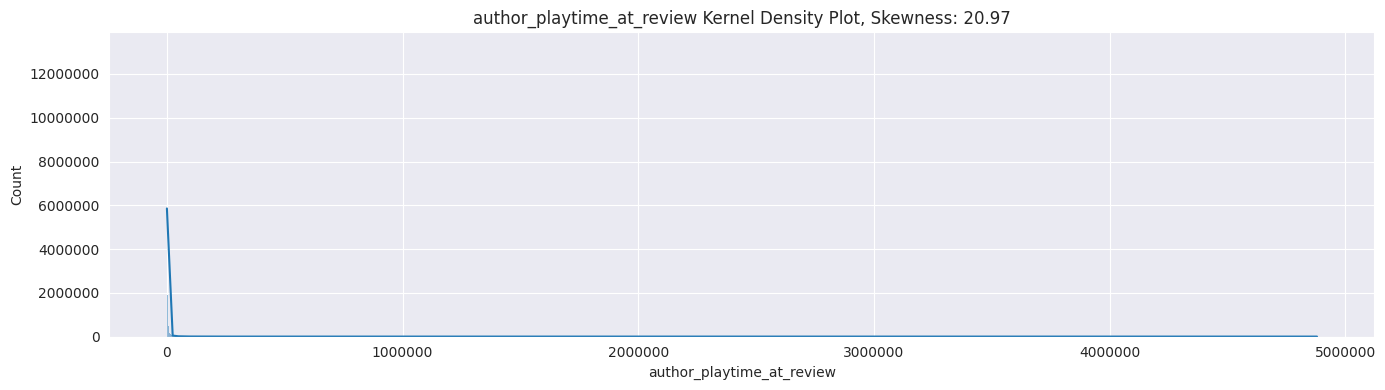

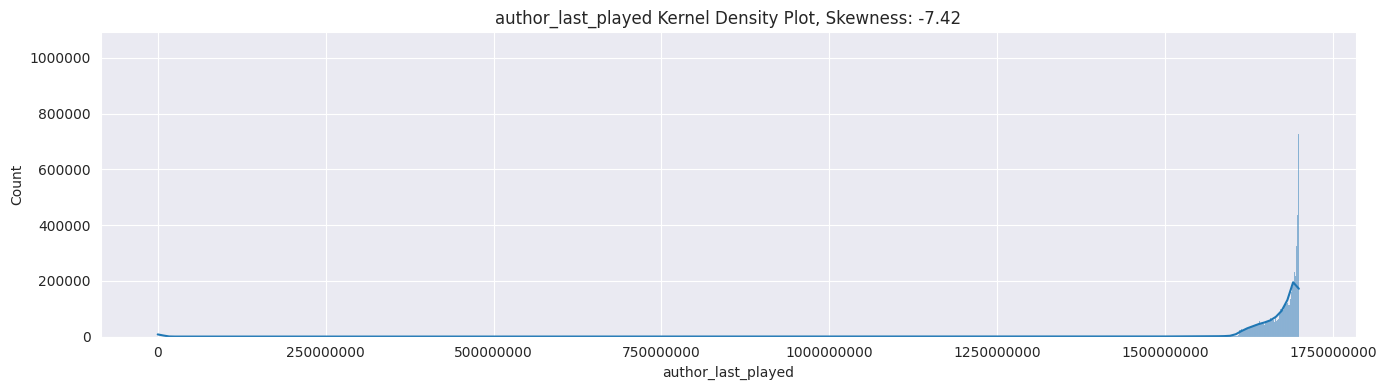

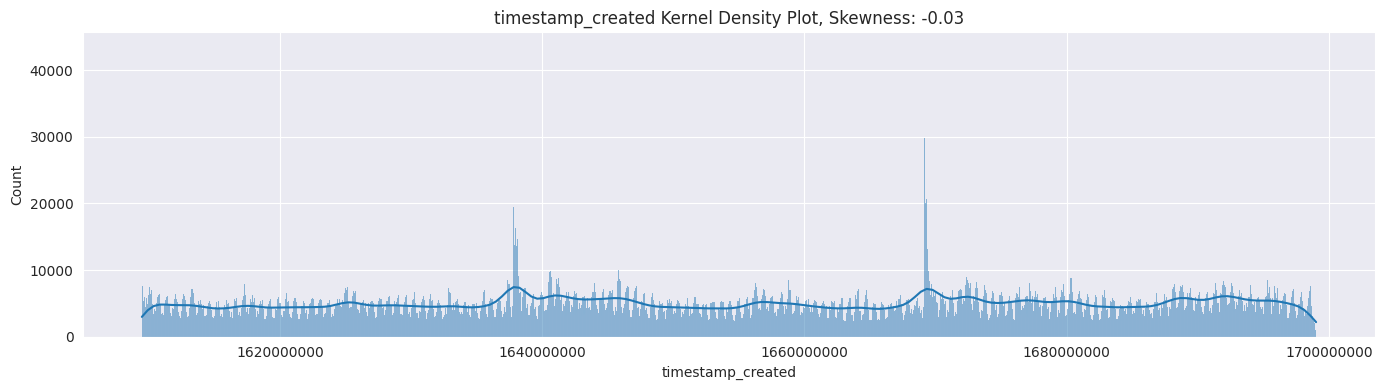

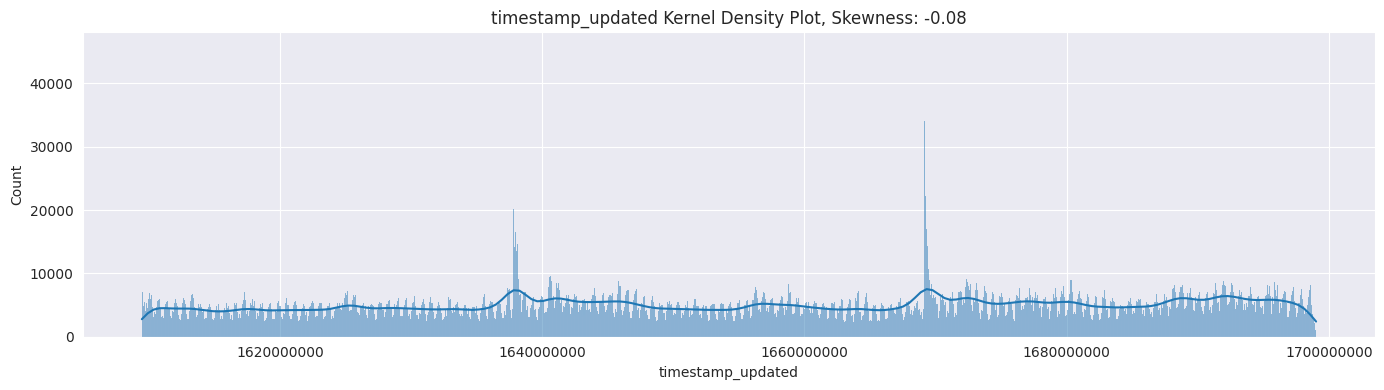

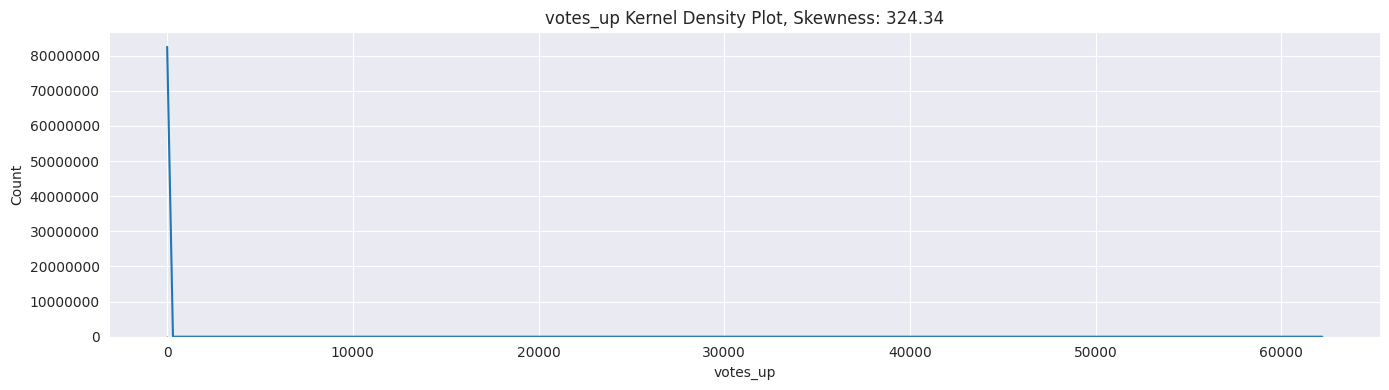

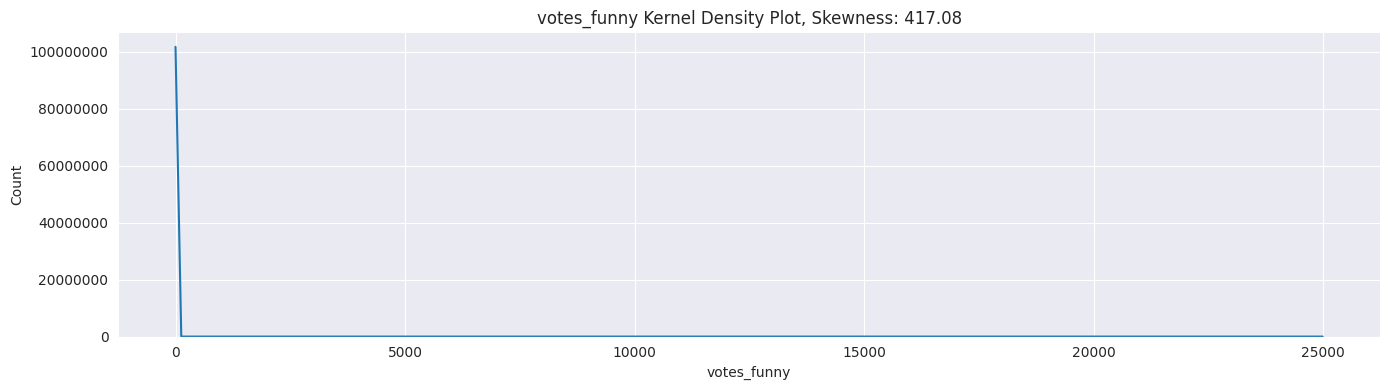

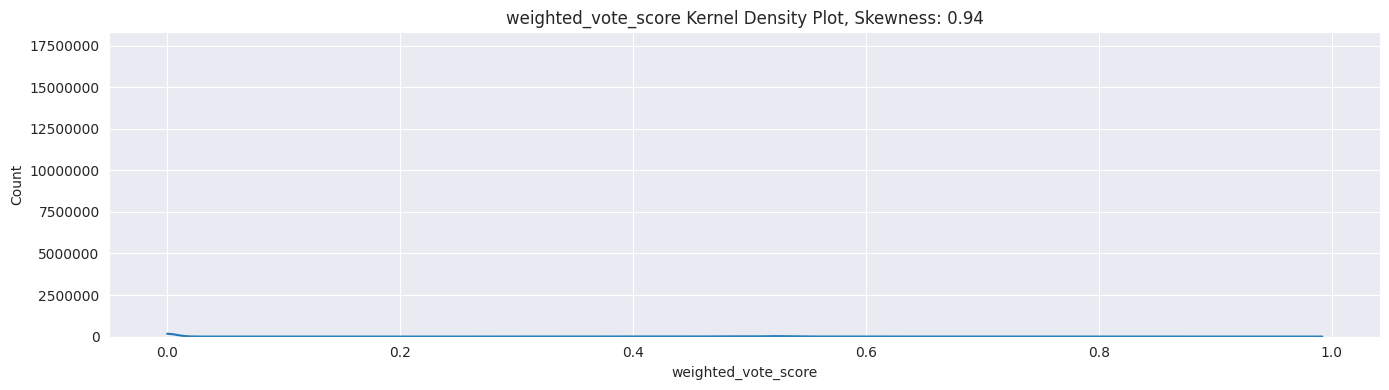

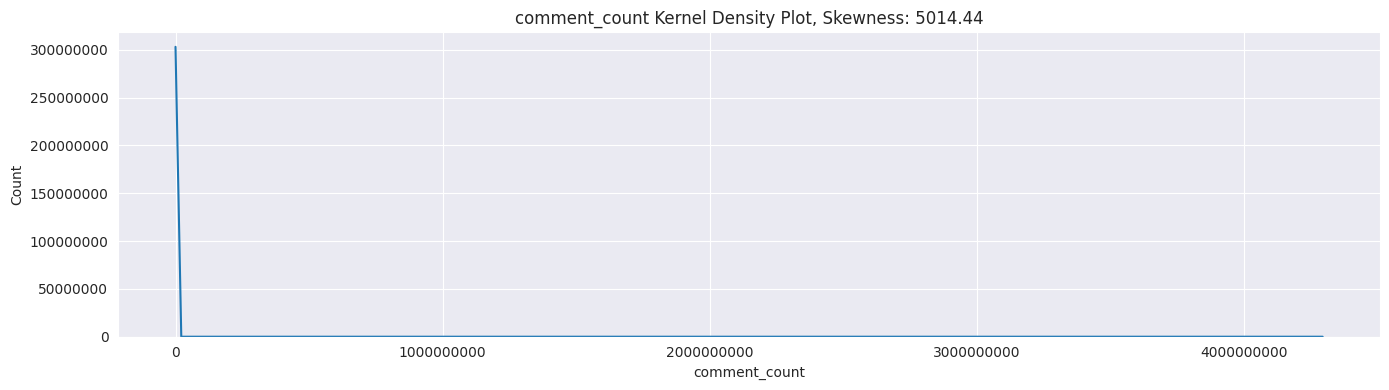

In [ ]:
# kernel density plot for each individual numerical variable

# Setting style
sns.set_style('darkgrid')

columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns

for idx, feature in enumerate(columns, 1):
    plt.figure(figsize=(14, 4))
    sns.histplot(df[feature], kde=True, bins='sqrt')
    plt.title(f'{feature} Kernel Density Plot, Skewness: {round(df[feature].skew(), 2)}')
    plt.ticklabel_format(style='plain')
    plt.tight_layout()
    plt.show()

Violin Plots

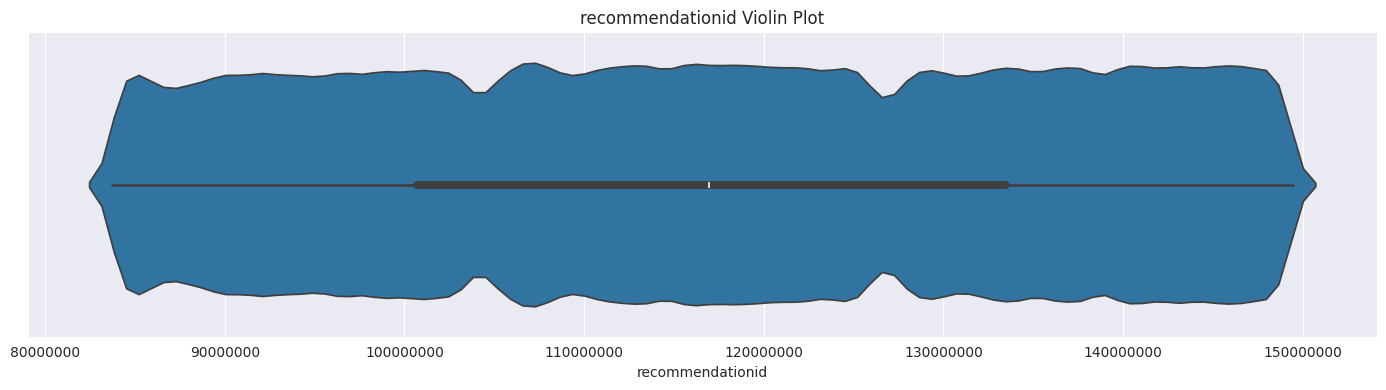

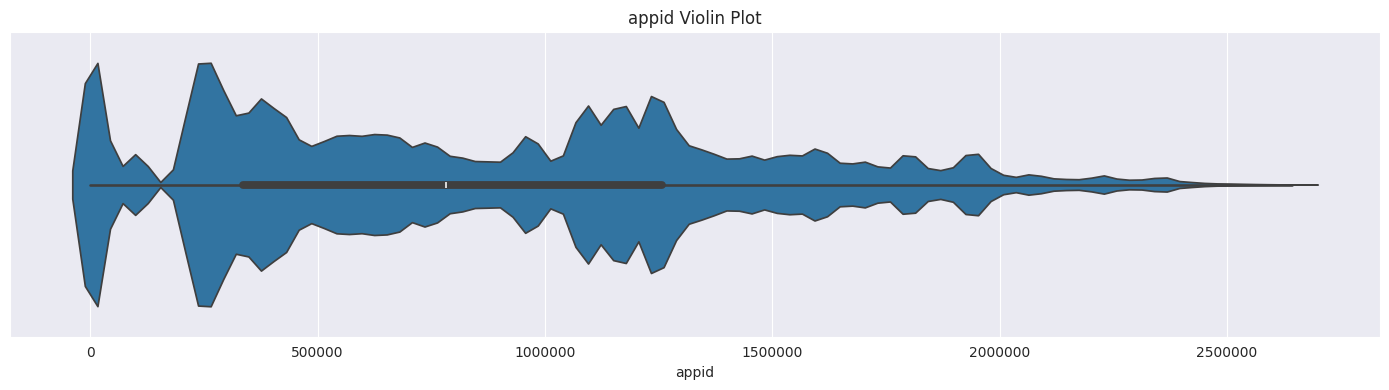

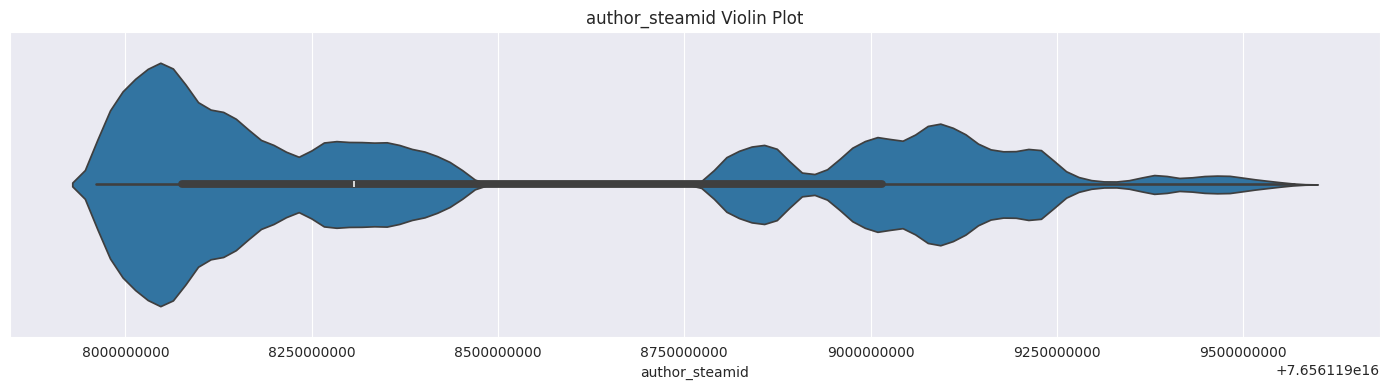

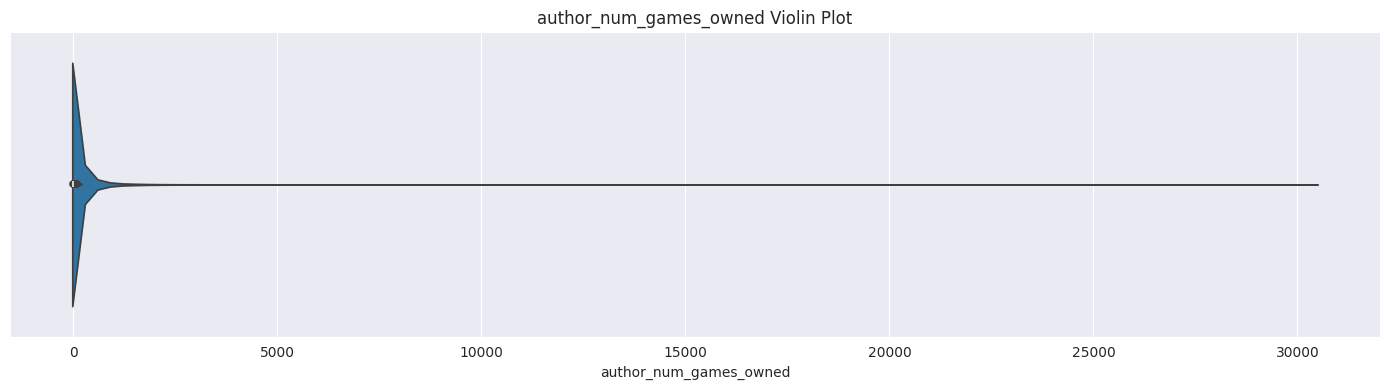

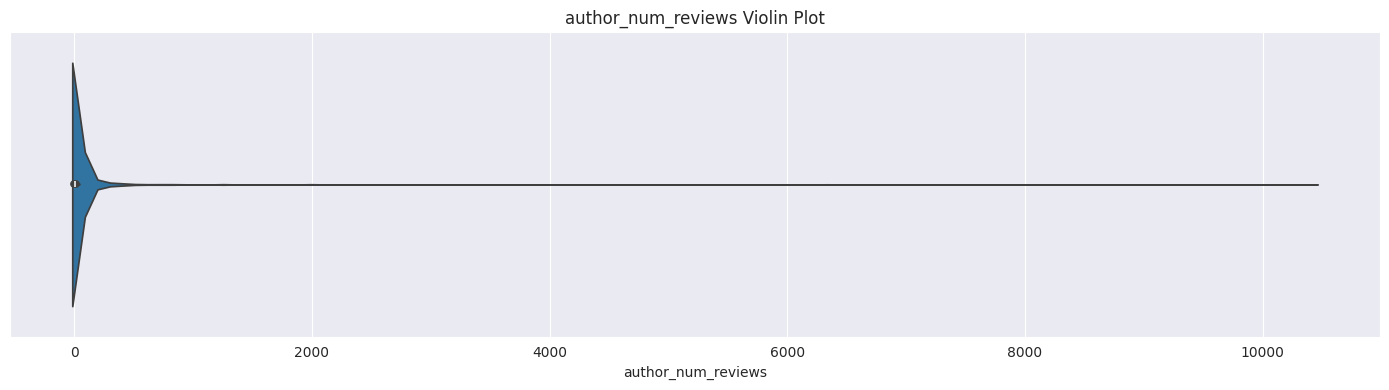

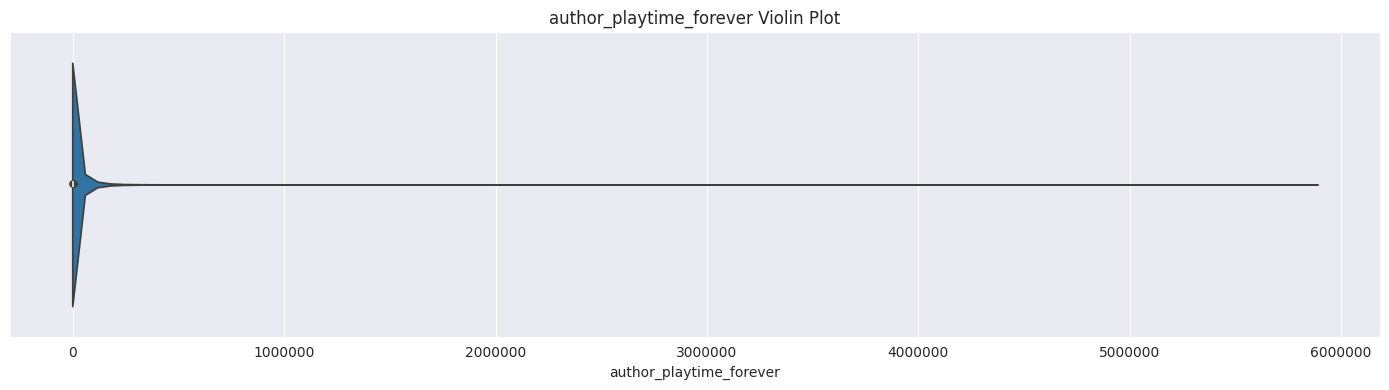

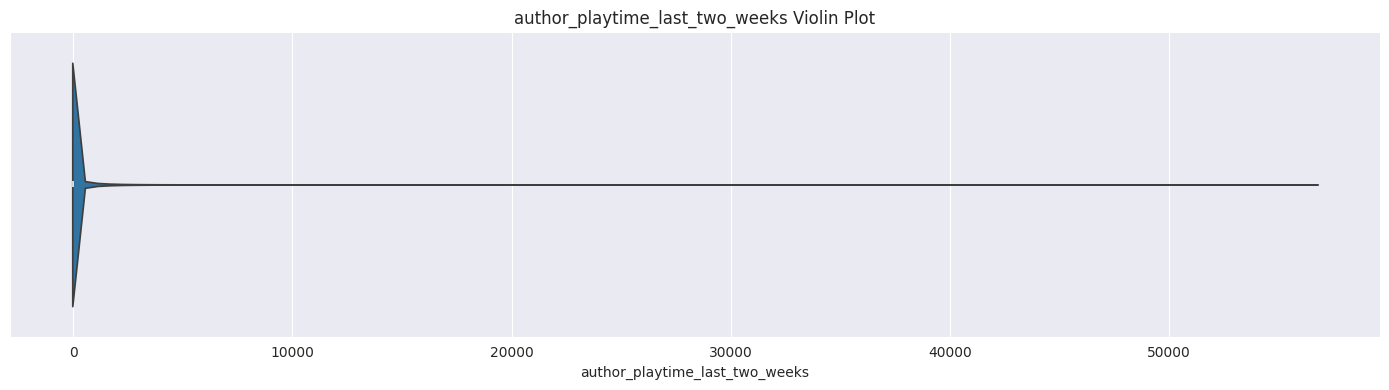

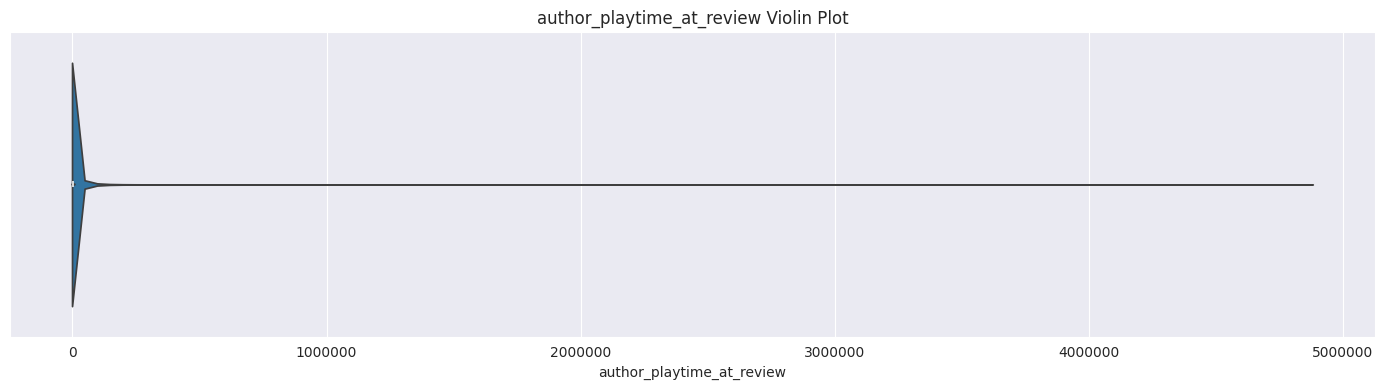

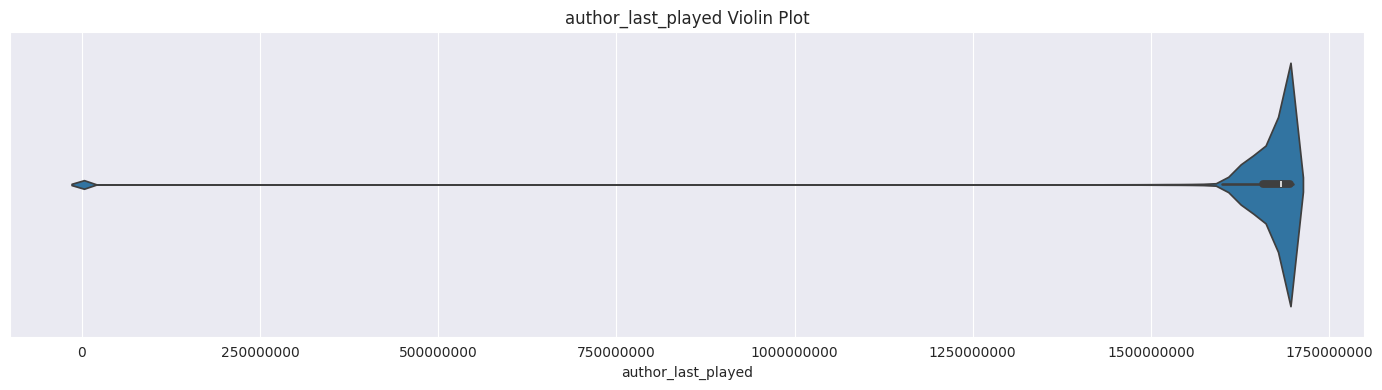

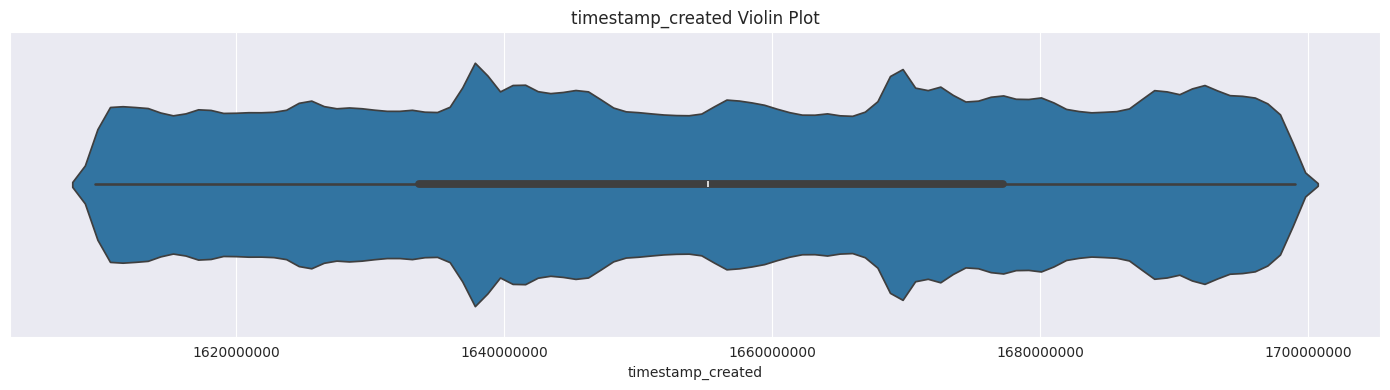

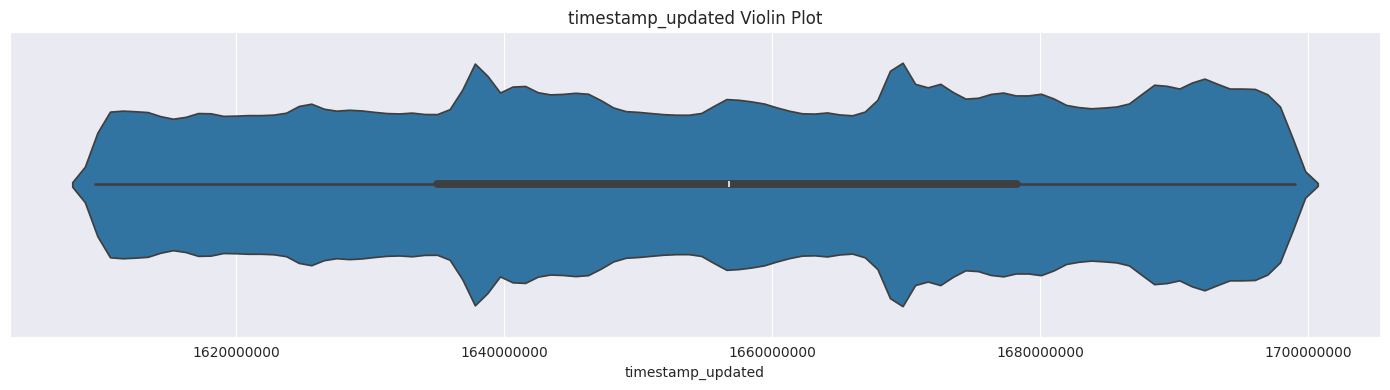

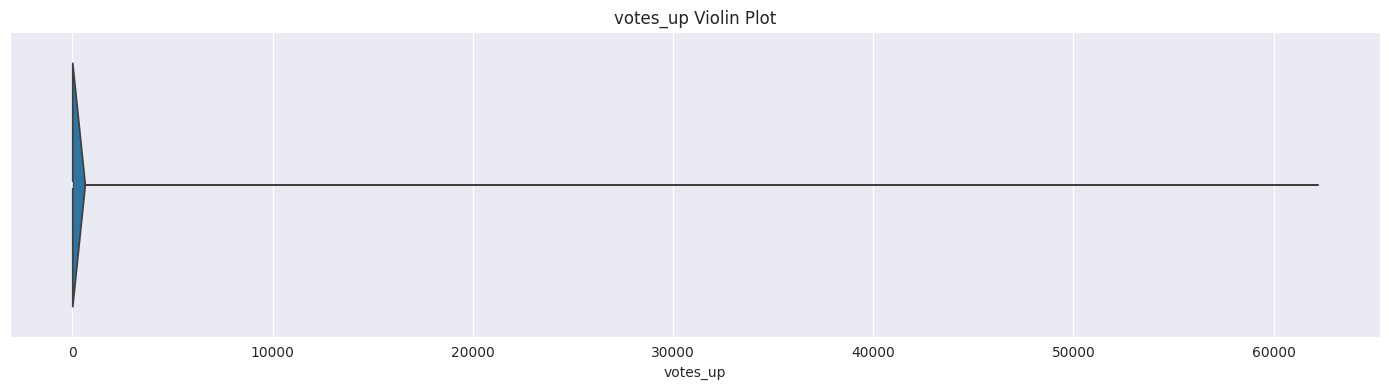

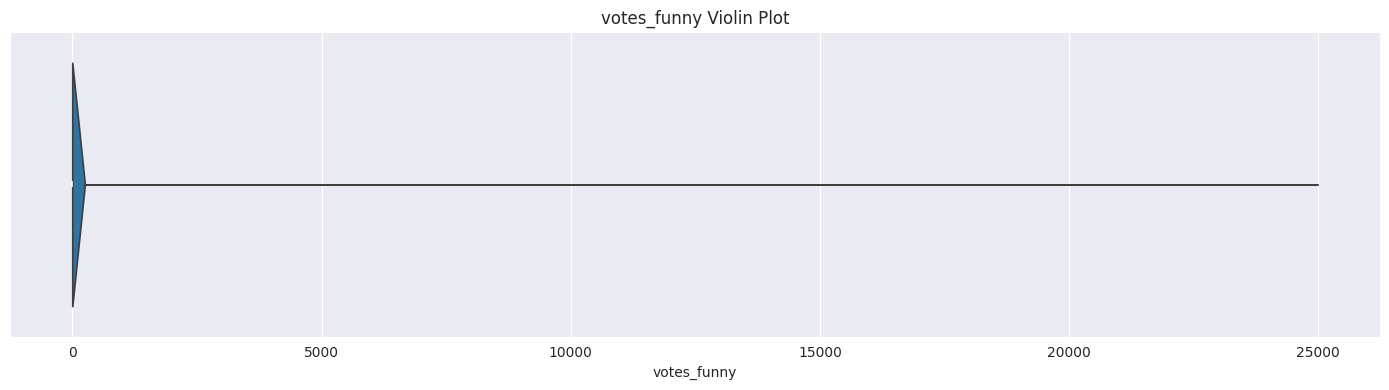

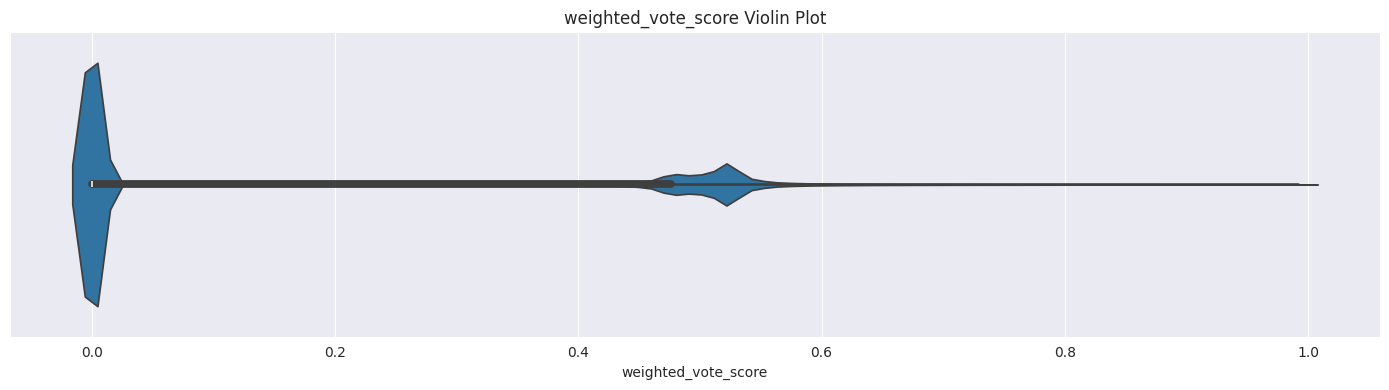

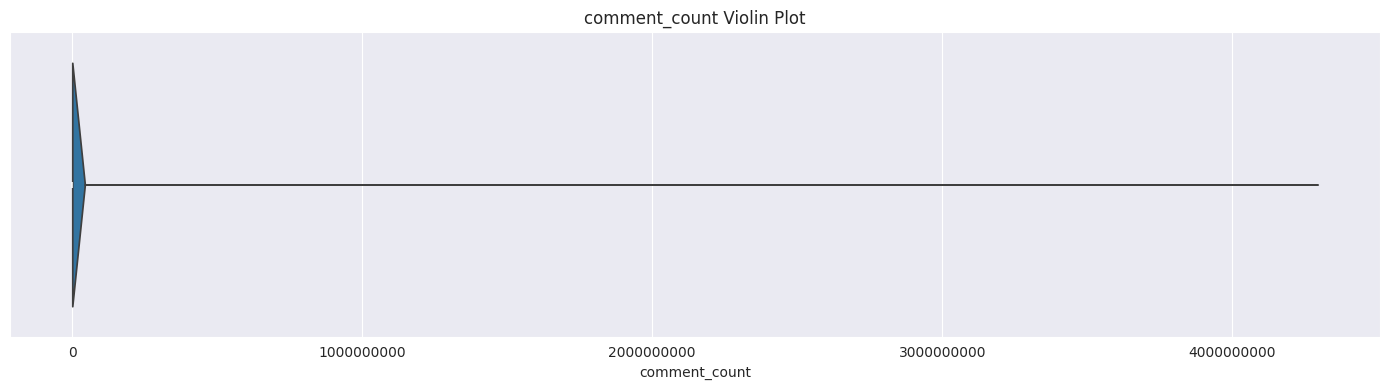

In [ ]:
# violin plots for every numerical feature in df
for idx, feature in enumerate(columns, 1):
    plt.figure(figsize=(14, 4))
    sns.violinplot(x=df[feature])
    plt.title(f'{feature} Violin Plot')
    plt.ticklabel_format(style='plain', axis='x')
    plt.tight_layout()
    plt.show()

Distribution of Reviews Per Game

appid  recommendationid  total_upvotes  ratio  \
0         10             11613          11268  0.970   
11613     20              1639           1448  0.883   
13252     30               795            707  0.889   
14047     40               472            386  0.818   
14519     50              5349           5093  0.952   

                            game  
0                 Counter-Strike  
11613      Team Fortress Classic  
13252              Day of Defeat  
14047         Deathmatch Classic  
14519  Half-Life: Opposing Force

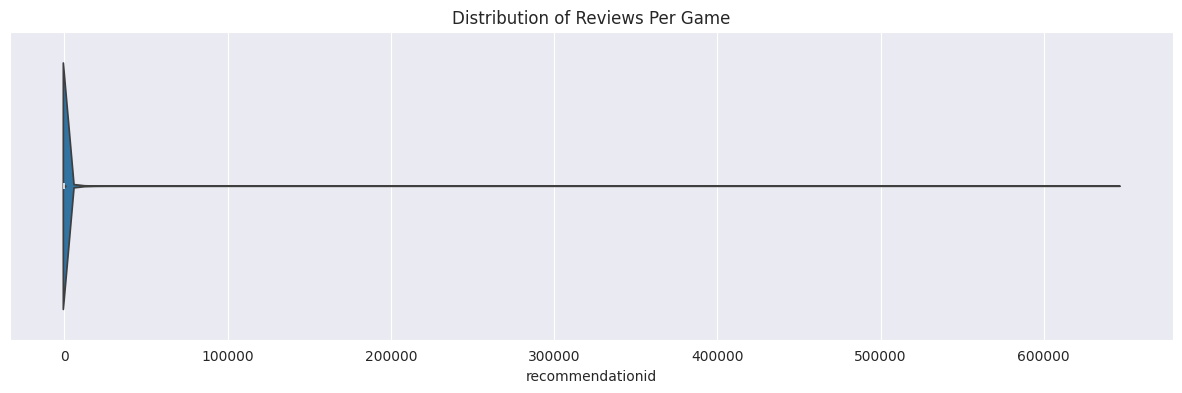

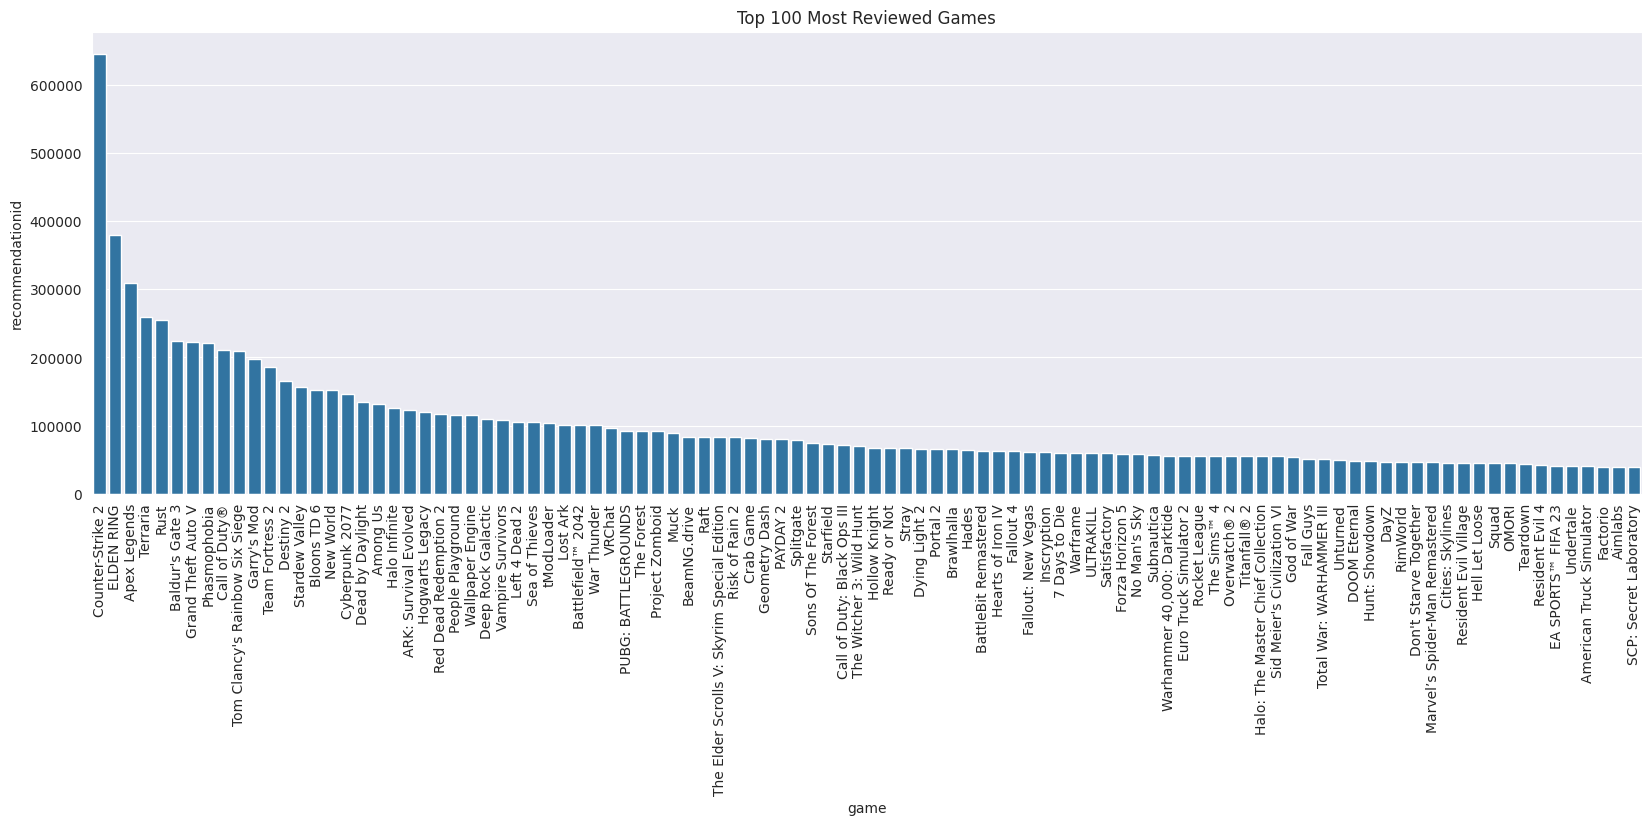

In [ ]:
df_appid_sum = df.groupby('appid')['voted_up'].apply(lambda x: x.value_counts(normalize=True))

# Resetting the index to bring 'appid' back as a column
df_appid_sum = df_appid_sum.unstack().fillna(0).reset_index()

# Grouping by appid, we want the count of the number of reviews
review_df = df.groupby('appid')['recommendationid'].count().reset_index()
review_df['total_upvotes'] = df.groupby('appid')['voted_up'].sum().reset_index()['voted_up']

# calculating the ratio of upvotes to total votes
review_df['ratio'] = review_df['total_upvotes'] / review_df['recommendationid']

# replace inf with 0's
review_df['ratio'] = review_df['ratio'].replace([np.inf, -np.inf], 0)
review_df['ratio'] = review_df['ratio'].fillna(0)

# merging in the title of the game based on appid
review_df = review_df.merge(df[['appid', 'game']], on='appid')
review_df = review_df.drop_duplicates(subset='appid')
display(review_df.head())

# distribution of total number of reviews per game
plt.figure(figsize=(15, 4))
sns.violinplot(x=review_df['recommendationid'])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribution of Reviews Per Game')
plt.show()

# distribution of the top 100 most reviewed games
plt.figure(figsize=(20, 6))
sns.barplot(y='recommendationid', x='game', data=review_df.sort_values(by='recommendationid', ascending=False).head(100))
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Top 100 Most Reviewed Games')
plt.show()

Distribution of Reviews Per User

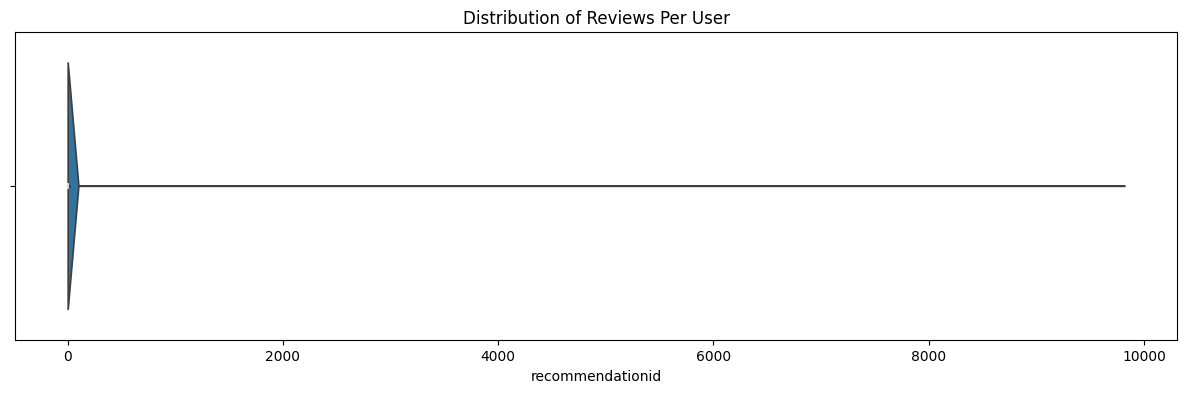

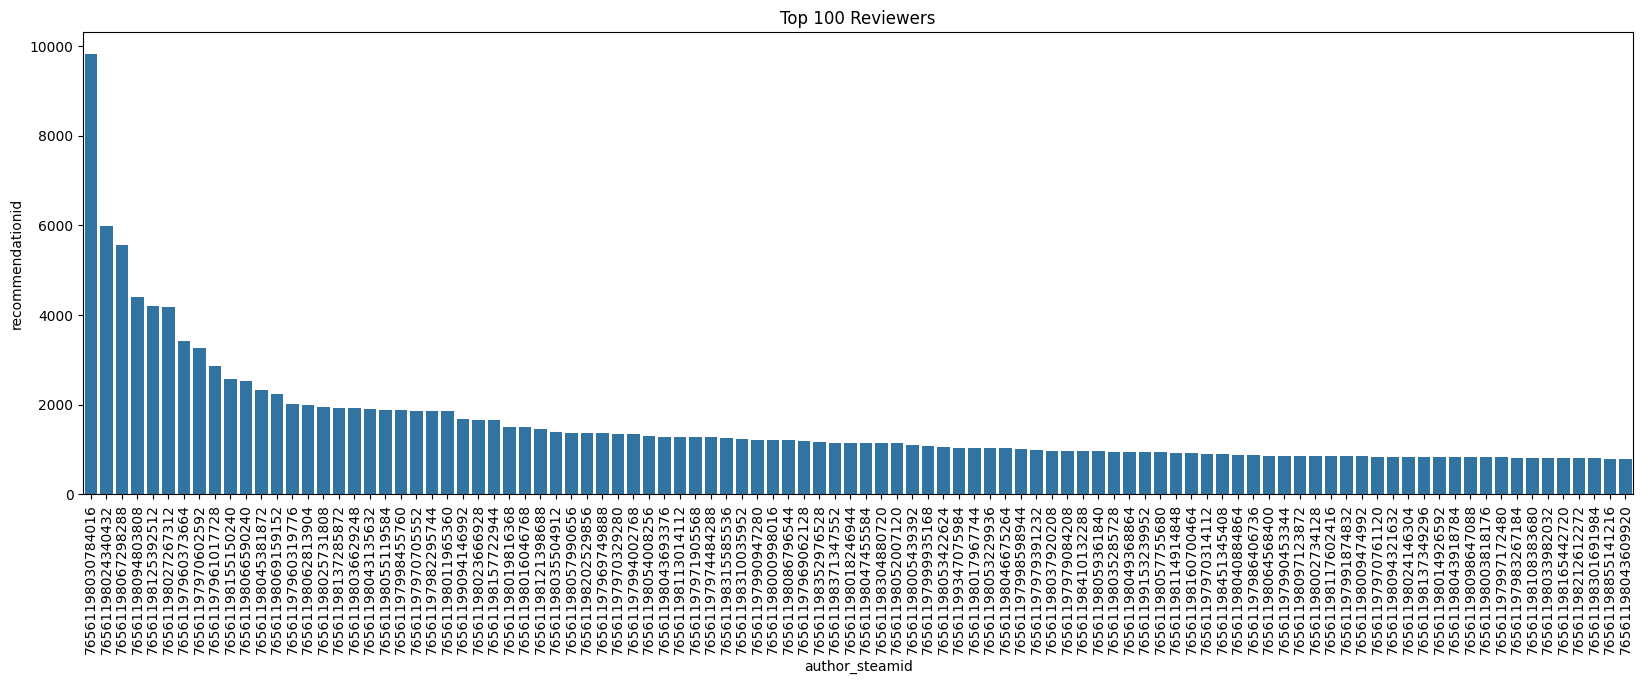

In [ ]:
# counting the total number of reviews, per author_steamid and storing it
user_df = df.groupby('author_steamid')['recommendationid'].count().reset_index()

# distribution of total number of reviews per author_steamid
plt.figure(figsize=(15, 4))
sns.violinplot(x=user_df['recommendationid'])
plt.title('Distribution of Reviews Per User')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

user_df = user_df.sort_values(by='recommendationid', ascending=False)

# distribution of the top 100 reviewers
plt.figure(figsize=(20, 6))
sns.barplot(y='recommendationid', x='author_steamid', data=user_df.head(100), order=user_df.head(100)['author_steamid'])
plt.xticks(rotation=90)
plt.title('Top 100 Reviewers')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Distribution of Ratings

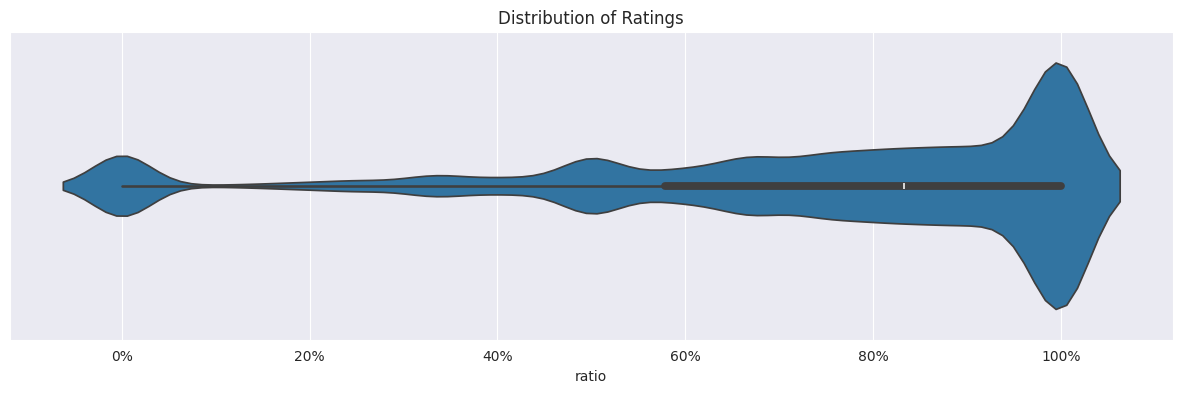

In [ ]:
# Viewing the distribution of Ratings
plt.figure(figsize=(15, 4))
sns.violinplot(x=review_df['ratio'])
plt.ticklabel_format(style='plain', axis='x')
# change xticks to show percentage range from 0% to 100%
plt.xticks(np.arange(0, 1.1, 0.2), ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('Distribution of Ratings')
plt.show()

Game Reviews Grouped By Month

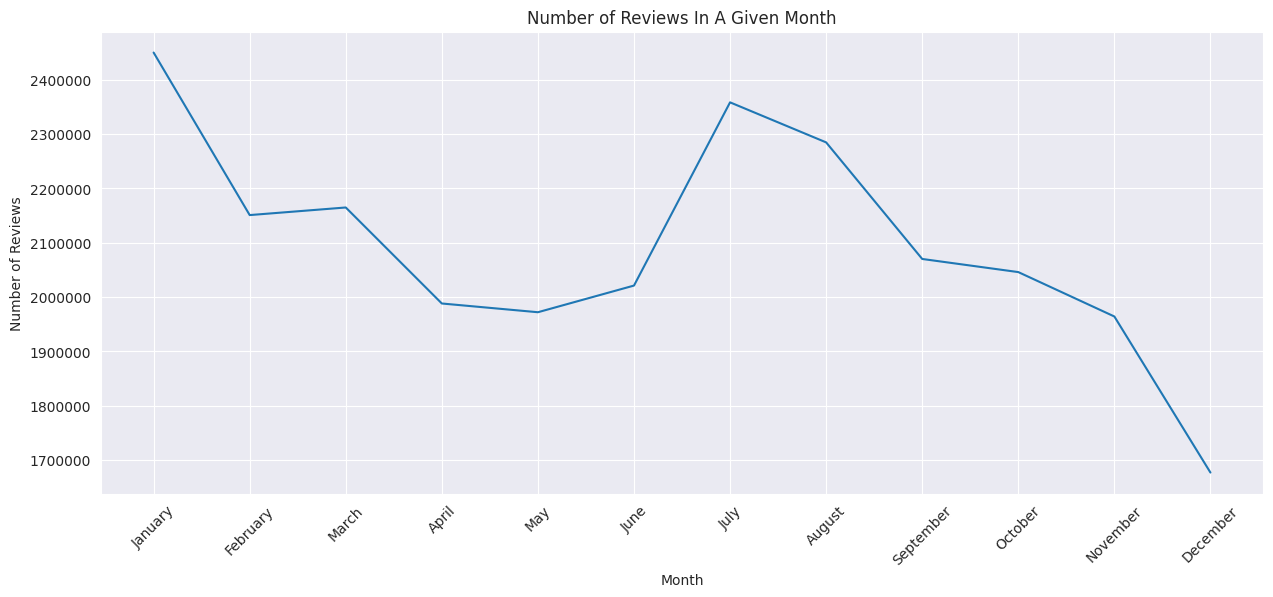

In [ ]:
# Creating a separate df which tallies the count of reviews, grouped by month
month_df = df.groupby(pd.to_datetime(df['timestamp_created'], unit='s').dt.month)['recommendationid'].count()

# creating a list of months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# creating a lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x=month_df.index, y=month_df.values)
plt.ticklabel_format(style='plain')
plt.xticks(range(1, 13), months, rotation=45)
plt.title('Number of Reviews In A Given Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

Top 50 Best Rated Games

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27809 (\N{CJK UNIFIED IDEOGRAPH-6CA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


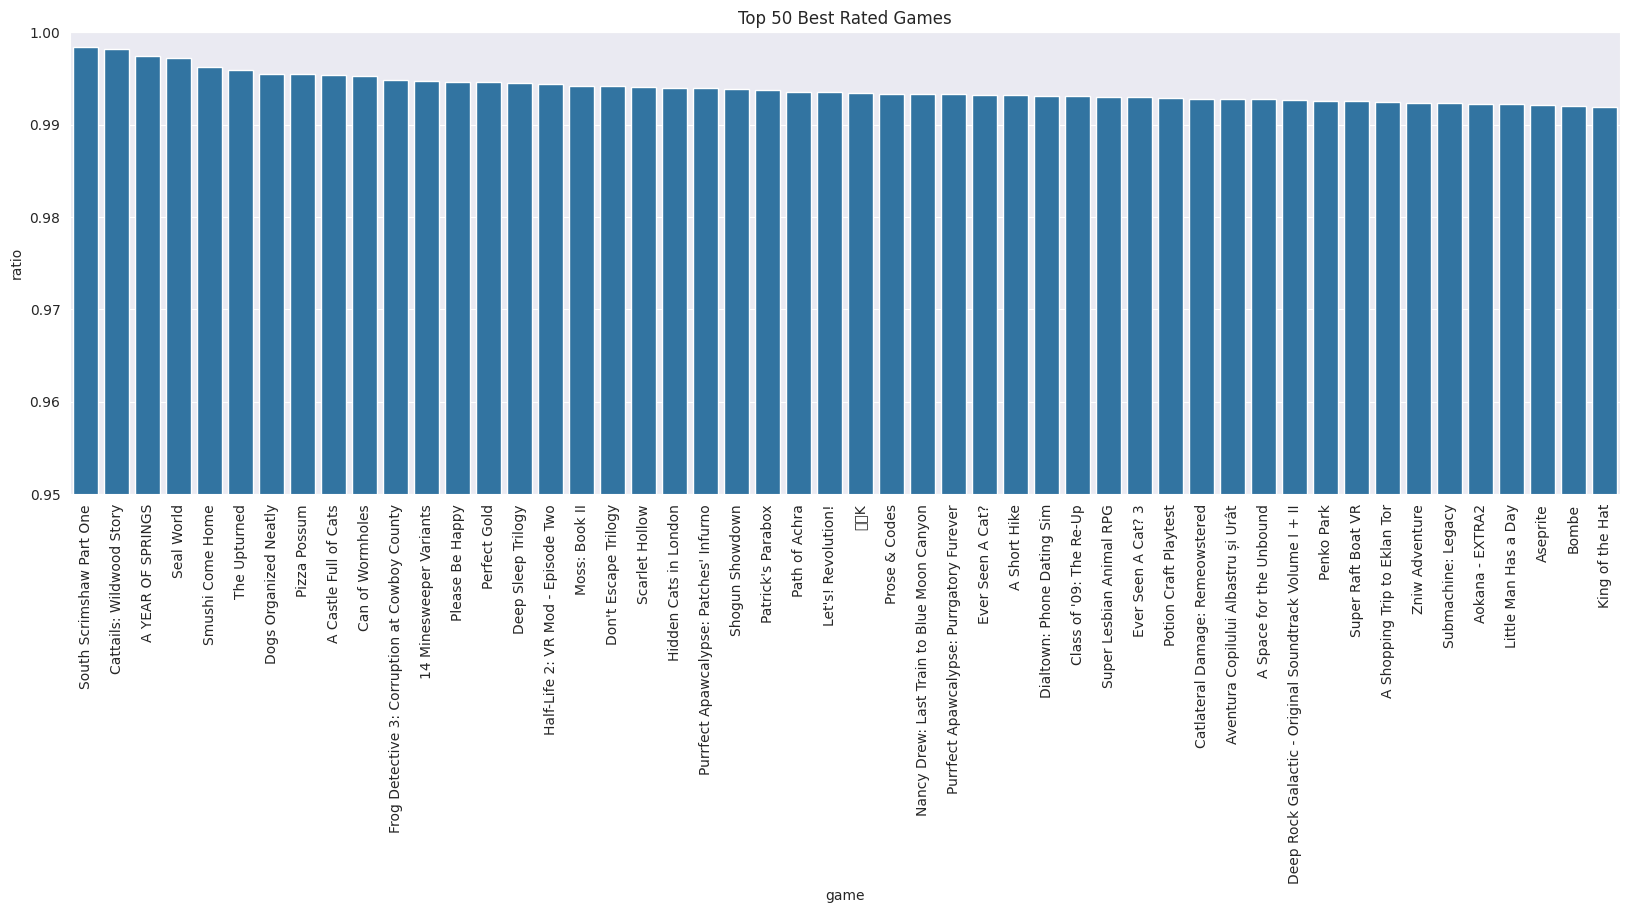

In [ ]:
# distribution of the top 100 most reviewed games
plt.figure(figsize=(20, 6))

# excluding games with a rating of 100%, these are typically small, indie title games with very few reviews
sns.barplot(y='ratio', x='game', data=review_df[review_df['ratio'] < 1].sort_values(by='ratio', ascending=False).head(50))
plt.ylim(0.95, 1)
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Top 50 Best Rated Games')
plt.show()

### 2.2.2 Correlation of Variables

An initial review of the correlations plot shows that most of the variables show little to no correlation with each other. Variables, like timestamp_created and timestamp_updated show obvious correlation given that they are a chronological indicator.

An interesting result is the high correlation between hidden_in_steam_china and recommendationid, which seems to indicate an underlying relationship, however this is not relevant for this project.

A further inspection of the the interaction terms again shows little correlation between all the variables. This bodes well for the modeling phase as remediation measures do not need to be taken for this aspect. One slight correlation to note, however, is between voted_up (whether or not the review was positive) and votes_funny (how humorous the community found the review). I suspect that perhaps in games which tend to be more favorably reviewed, users will have a light-hearted tone to their written reviews, though this is conjecture.

Correlation Plot

<Axes: >

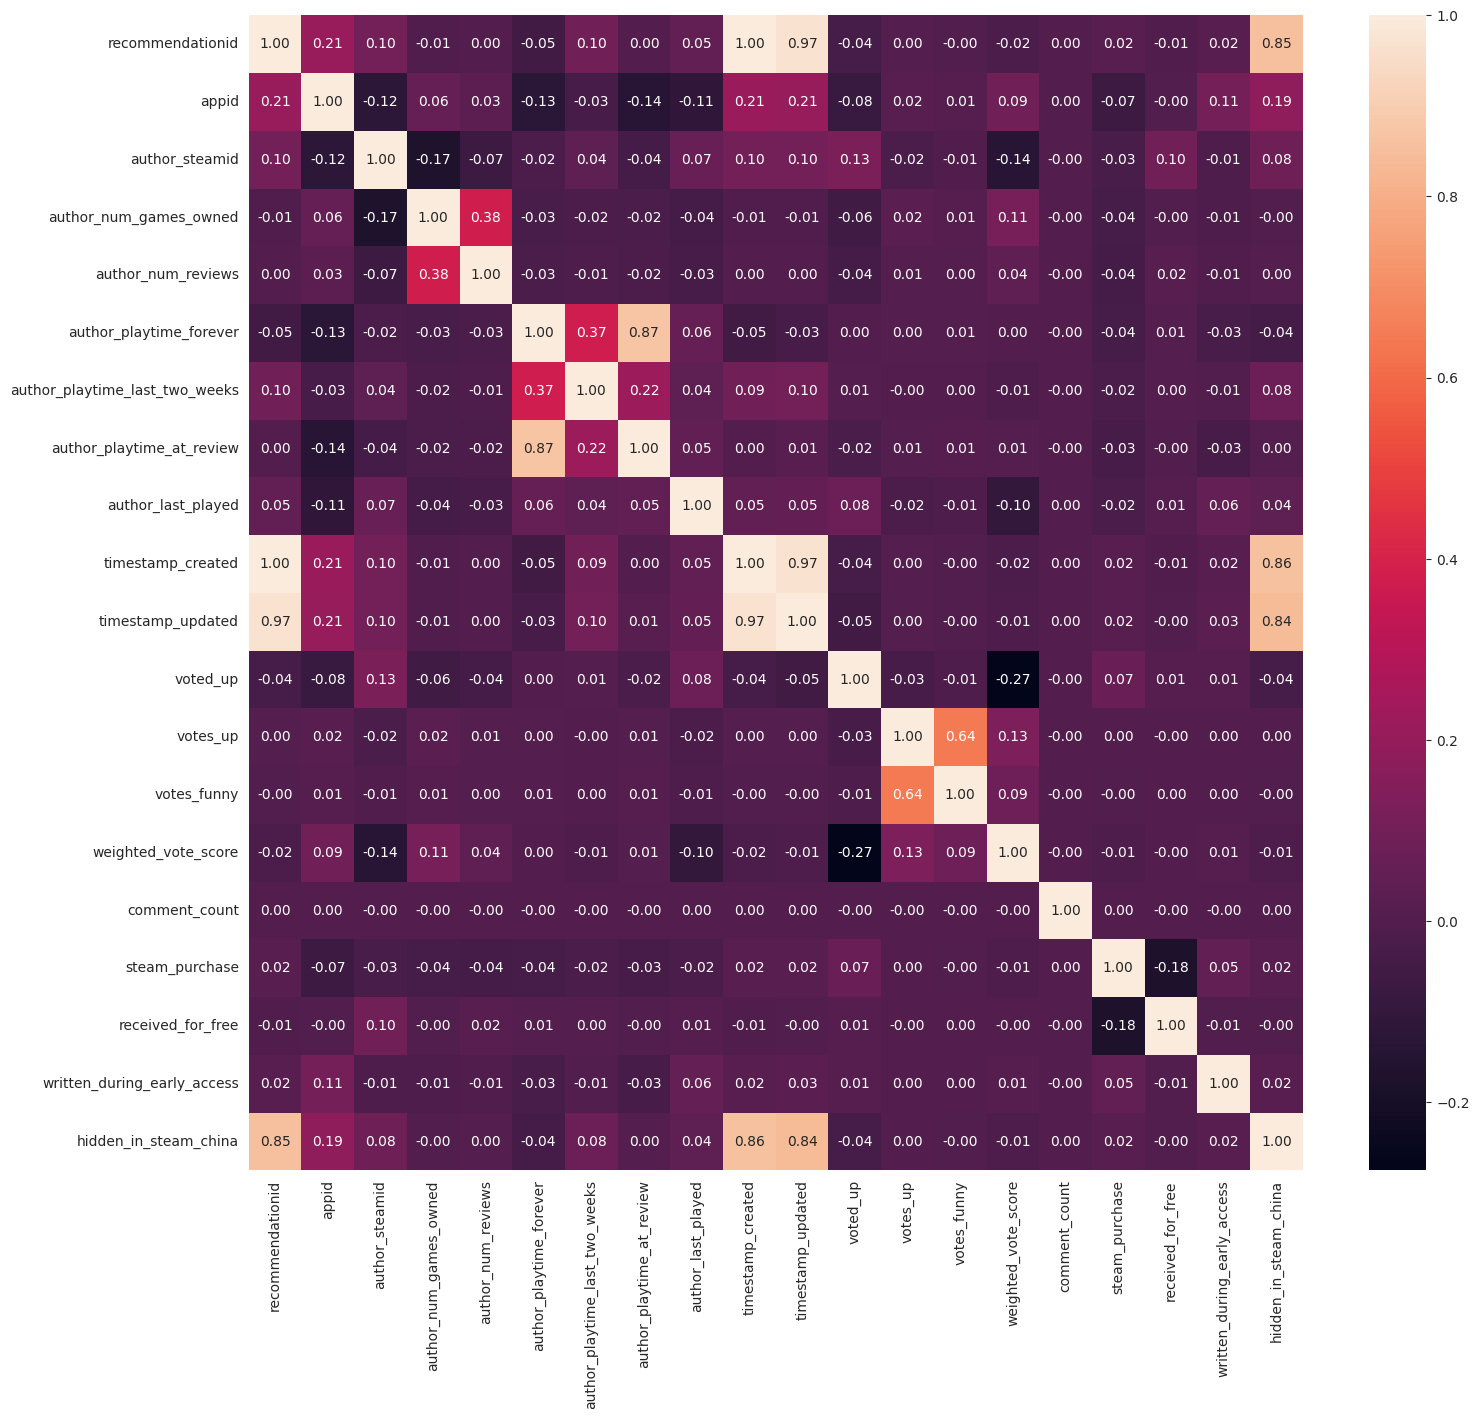

In [ ]:
# filtering out columns with text
text_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype == 'string']

# correlation heatmap using the filter to skip certain columns
corr = df.drop(columns=text_cols).corr()
plt.figure(figsize=(17,15))
sns.heatmap(corr, annot=True, fmt='.2f')


<Axes: >

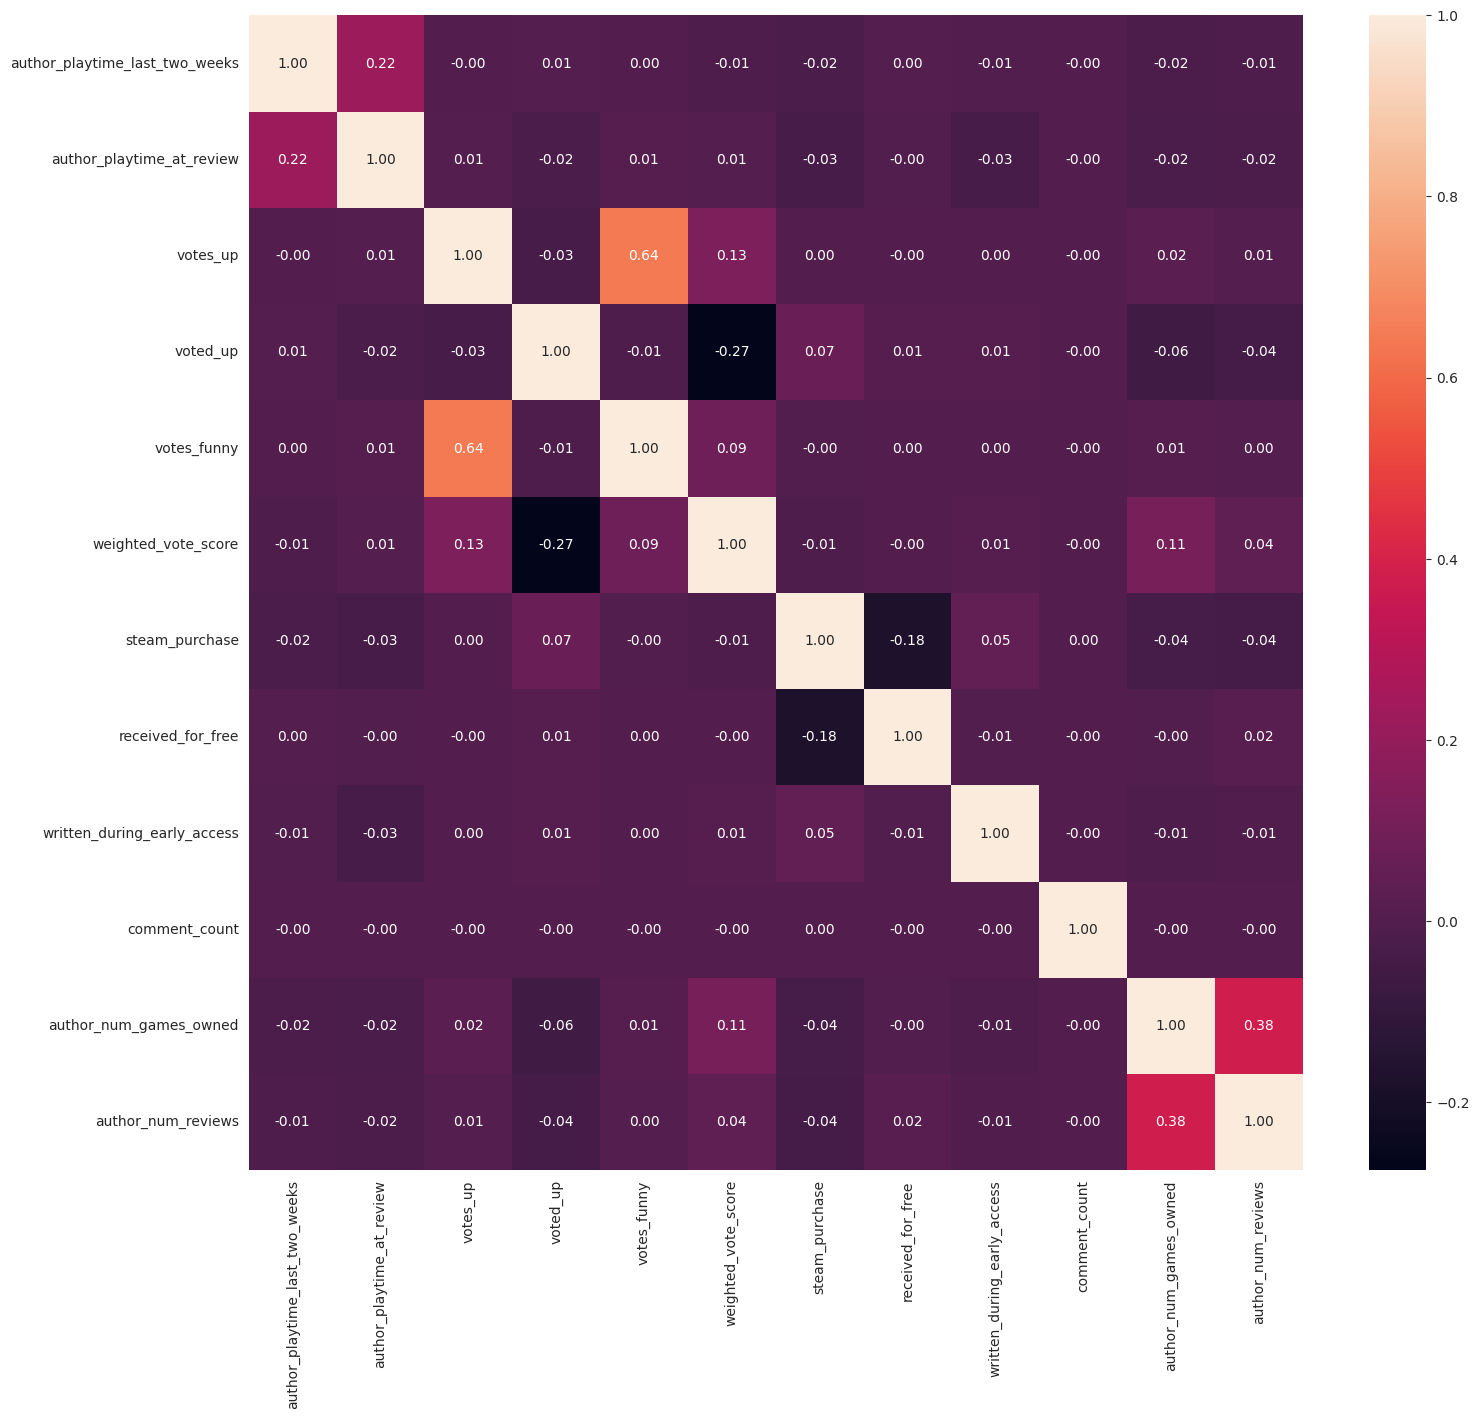

In [ ]:
# correlation plot of our interaction terms
interaction_terms = ['author_playtime_last_two_weeks', 'author_playtime_at_review', 'votes_up',
        'voted_up', 'votes_funny', 'weighted_vote_score', 'steam_purchase',
        'received_for_free', 'written_during_early_access', 'comment_count',
        'author_num_games_owned', 'author_num_reviews']

plt.figure(figsize=(17,15))
sns.heatmap(df[interaction_terms].corr(), annot=True, fmt='.2f')

### 2.2.3 Distribution of Words in Reviews

One final step before moving on to remediation measures is to inspect the written reviews of the dataset. While these reviews will ultimately NOT be used for this project in order to reduce project scope, it is nonetheless important to have a baseline understanding of the data.

**Comparing Top 100 Words**

From the wordclouds, we can see that there is a large amount of similarity. We also see the impact of having large amounts of reviews for a select few games. One example is the prevalence of the words "counter", "terrorists" and "bomb" for positive reviews. These words are all commonly used in-game lingo for the game Counter-Strike 2 and therefore we should expect their use within the reviews. We can also note that despite this dataset being composed of seemingly only english based reviews, there are still several instances of words which could not be rendered in the wordcloud. These can indicate either the use of emoticons, other languages, or other special characters that are permissible within Steam reviews.

Further analysis of the text would be required, however that falls outside the scope of this project.

Most Used Words in Positive Reviews

<ipython-input-29-dcd9c49579cc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['total_upvotes'] = df.groupby('appid')['voted_up'].sum().reset_index()['voted_up']


appid     author_steamid  \
3323        10  76561198261895168   
7398        10  76561197960567776   
66284  1002300  76561198857906816   
60961  1000410  76561198111150544   
6803        10  76561199015858592   

                                                  review  voted_up  \
3323   aqui foi onde se iniciou muitas historias... u...      True   
7398                                 Still a great game.      True   
66284  >Have sex with bunnyman to replenish health. >...      True   
60961  Great............................................      True   
6803   𝙏𝙝𝙚 𝙥𝙝𝙖𝙣𝙩𝙤𝙢, 𝙚𝙭𝙩𝙚𝙧𝙞𝙤𝙧 𝙡𝙞𝙠𝙚 𝙛𝙞𝙨𝙝 𝙚𝙜𝙜𝙨 𝙞𝙣𝙩𝙚𝙧𝙞𝙤𝙧 ...      True   

       weighted_vote_score  total_upvotes  
3323                 0.583     225003.000  
7398                 0.524     175089.000  
66284                0.529     127847.000  
60961                0.478     106326.000  
6803                 0.731     105300.000

appid     author_steamid  \
58247  1000360  76561198258201152   
5773        10  76561198043487552   
6           10  76561198143459824   
5067        10  76561198090104096   
57744  1000360  76561199030312944   

                                                  review  voted_up  \
58247                      It looks better in the video.     False   
5773   This game is not already dead , so we need som...     False   
6      cs2 update made the game barely playable on my...     False   
5067   Was way better when i was playing this back wh...     False   
57744                              runs slow on my deck      False   

       weighted_vote_score  total_upvotes  
58247                0.444      51771.000  
5773                 0.476      44466.000  
6                    0.537      21026.000  
5067                 0.476      20865.000  
57744                0.435      16677.000

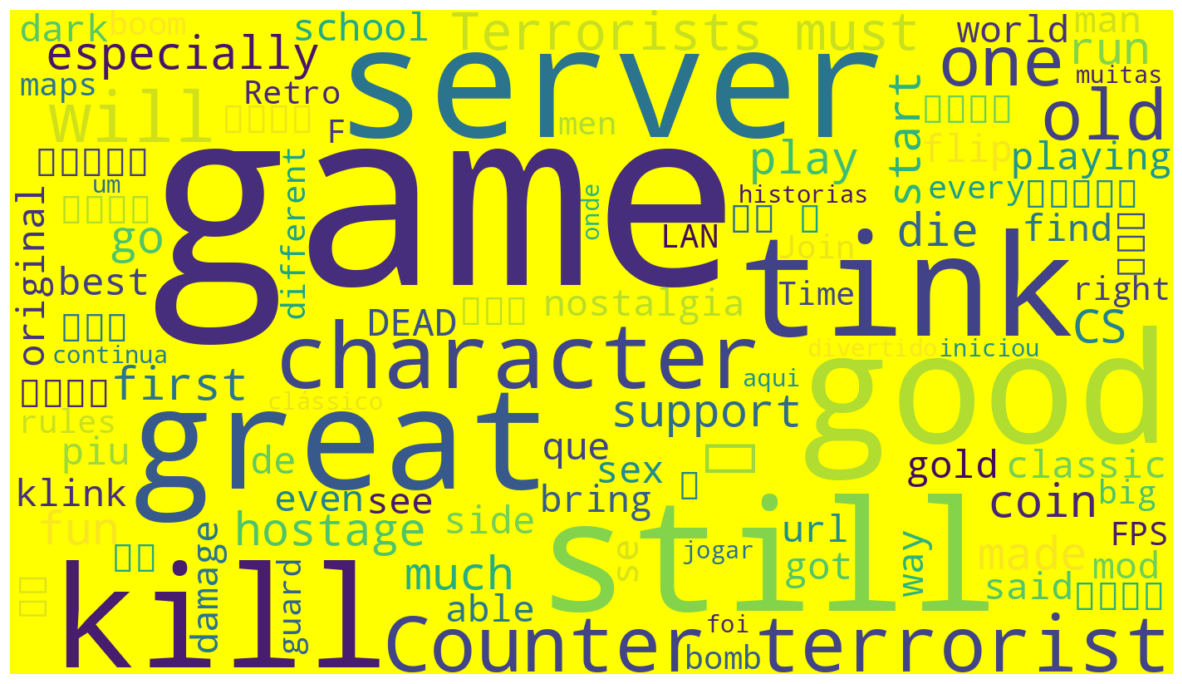

In [ ]:
review_df = df[['appid', 'author_steamid', 'review', 'voted_up', 'weighted_vote_score']]

review_df['total_upvotes'] = df.groupby('appid')['voted_up'].sum().reset_index()['voted_up']

# sorting by most upvoted
review_df = review_df.sort_values(by='total_upvotes', ascending=False)

# setting NaN values to 0
review_df['total_upvotes'] = review_df['total_upvotes'].fillna(0)

# from the top 50 most upvoted games we extract the reviews into a separate dataframe to use with wordcloud
positive_reviews = review_df[(review_df['voted_up'] == True) & (review_df['weighted_vote_score'] > 0)].head(50)

negative_reviews = review_df[(review_df['voted_up'] == False) & (review_df['weighted_vote_score'] > 0)].head(50)

display(positive_reviews.head())
display(negative_reviews.head())

# creating wordcloud of top 50 most used words for positive reviews
import wordcloud
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="yellow", stopwords = STOPWORDS, max_words=100, max_font_size= 300,  width=1400, height=800)
wc.generate(" ".join(positive_reviews["review"]))
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=108), interpolation="bilinear")
plt.axis('off')
plt.show()

Most Used Words in Negative Reviews

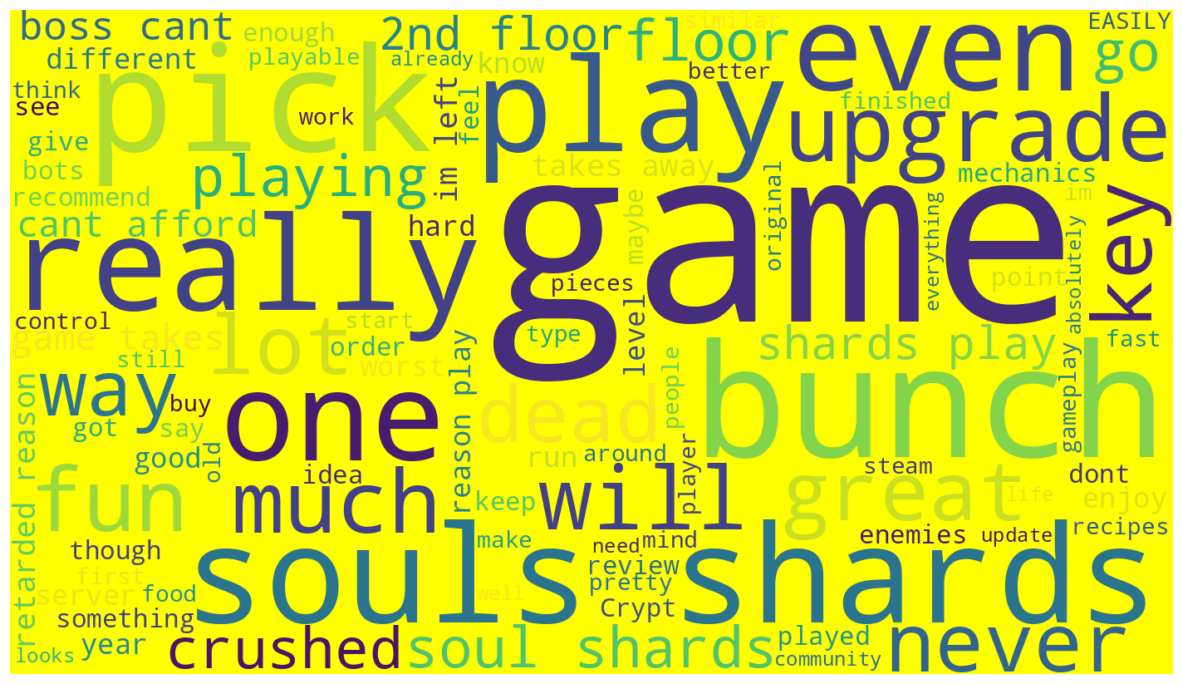

In [ ]:
plt.figure(figsize=(15,15))
wc.generate(" ".join(negative_reviews["review"]))
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=108), interpolation="bilinear")
plt.axis('off')
plt.show()

## 2.3 Remediation Steps

From the KDE and Violin plots in the previous section, I conclude that there are some remediations that must occur, particularly with regards to data distribution.

**Variance Inflation Factor (VIF)**

We check to confirm our initial notion that the lack of correlation between interaction terms will result in little to no multicollinearity.

**Q-Q Plots**

The use of Q-Q plots is to inspect the linearity assumption of interaction terms that are not of boolean type. In all cases, we observe a clear violation of the linearity assumption, with strong departures from linearity towards the top.

**Box-Cox Transformation and Follow-up Plots**

In order to rectify these issues, I opt to use the Box-Cox method of transforming the data. This allows each variable to scaled most appropriately in accordance to the optimal lambda. The most common transformations are as follows:

$$
y(\lambda) =  \begin{cases}
      \hfill -3   \hfill & \text Y^{-3} = \frac{1}{Y^3} \\
      \hfill -2 \hfill & \text Y^{-2} = \frac{1}{Y^2} \\
      \hfill -1 \hfill & \text Y^{-1} = \frac{1}{Y^1} \\
      \hfill -0.5 \hfill & \text Y^{-0.5} = \frac{1}{\sqrt(Y)} \\
      \hfill 0 \hfill & \text log(Y) \\
      \hfill 0.5 \hfill & \text Y^{0.5} = \sqrt{Y} \\
      \hfill 1 \hfill & \text Y^{1} = Y \\
      \hfill 2 \hfill & \text Y^{2} \\
      \hfill 3 \hfill & \text Y^{3} \\
  \end{cases}
$$

A plot is provided for each variable to show the decision point. We see a mixture of transformations, include $log(Y)$, $Y^{-0.5}$, $Y^{-1}$, and $Y^{0.5}$.

Q-Q plots showing the linearity of the variables post-transformation indicate that the transformation yielded decent results. We can not more clearly see that there is a violation of linearity when it comes to the zero-inflation of the variables, but not much can be done about that.

In [ ]:
# First, checking the VIF levels of our interaction terms
X = df[['author_playtime_last_two_weeks', 'author_playtime_at_review', 'votes_up',
        'voted_up', 'votes_funny', 'weighted_vote_score', 'steam_purchase',
        'received_for_free', 'written_during_early_access', 'comment_count',
        'author_num_games_owned', 'author_num_reviews']].astype(float)

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(X)

variables   VIF
0   author_playtime_last_two_weeks 1.076
1        author_playtime_at_review 1.103
2                         votes_up 1.733
3                         voted_up 2.852
4                      votes_funny 1.714
5              weighted_vote_score 1.337
6                   steam_purchase 2.747
7                received_for_free 1.063
8      written_during_early_access 1.130
9                    comment_count 1.000
10          author_num_games_owned 1.256
11              author_num_reviews 1.189

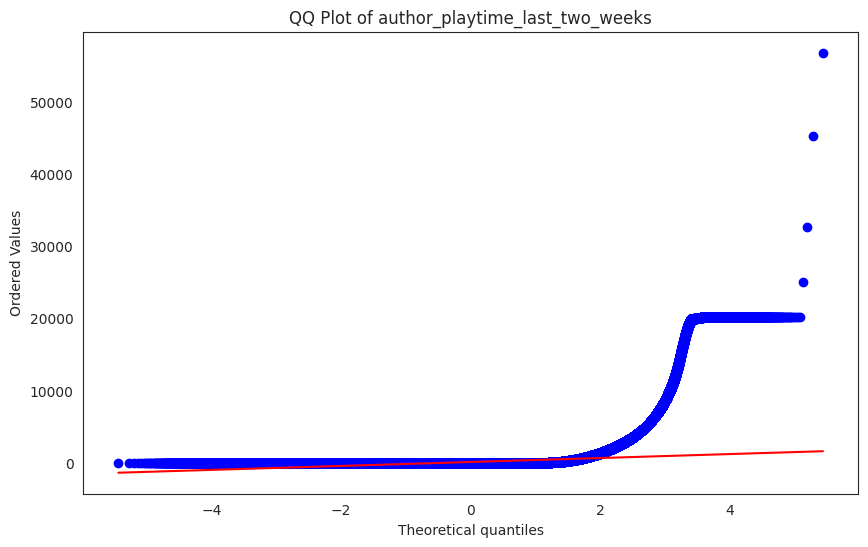

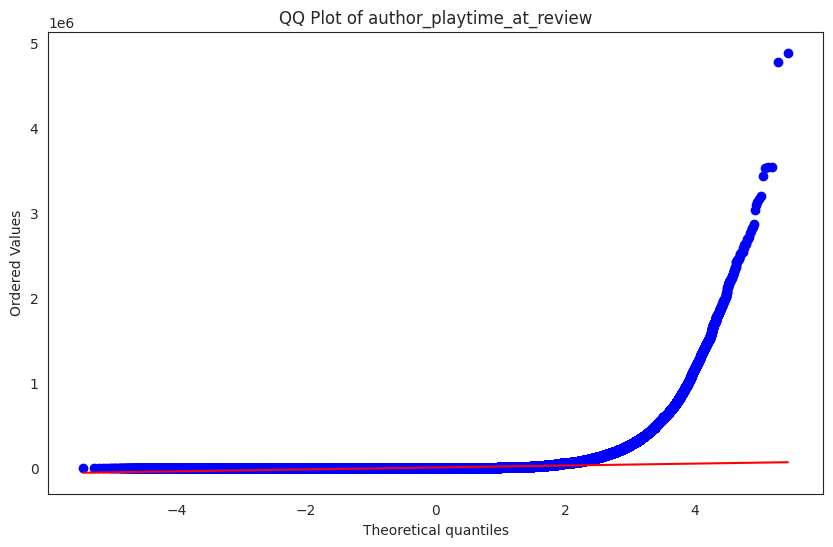

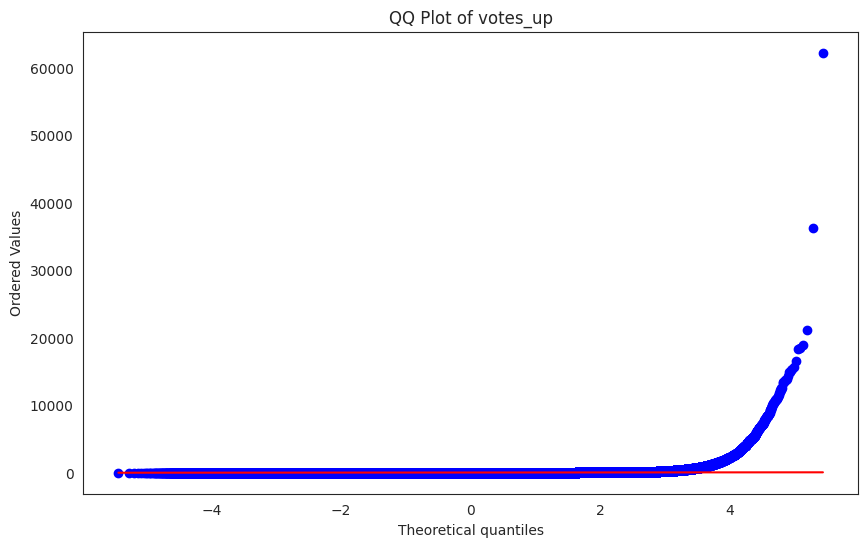

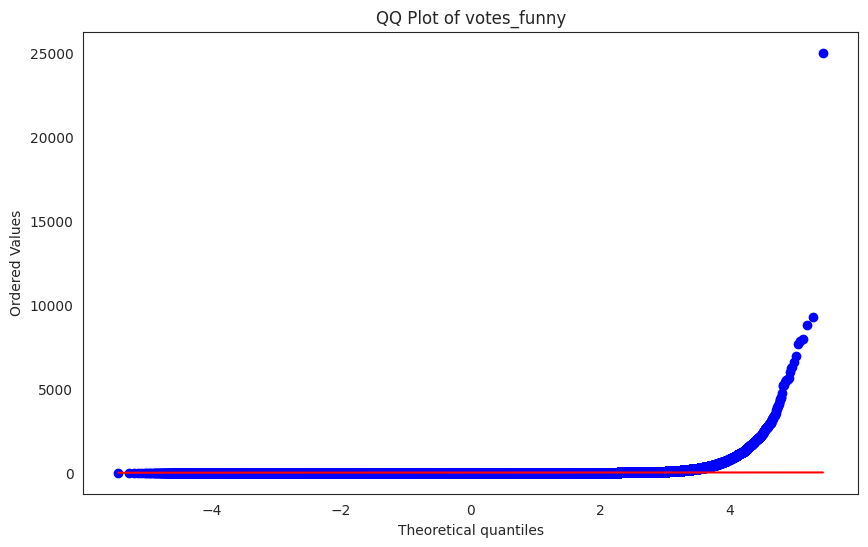

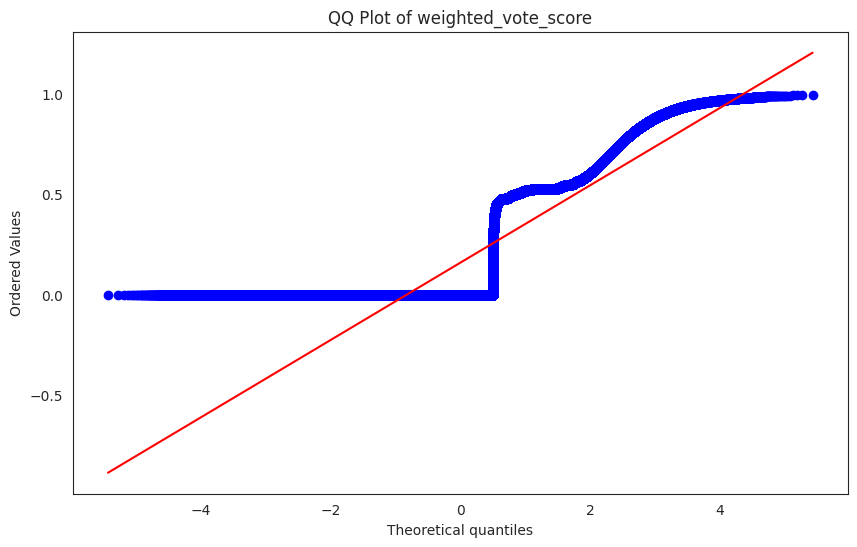

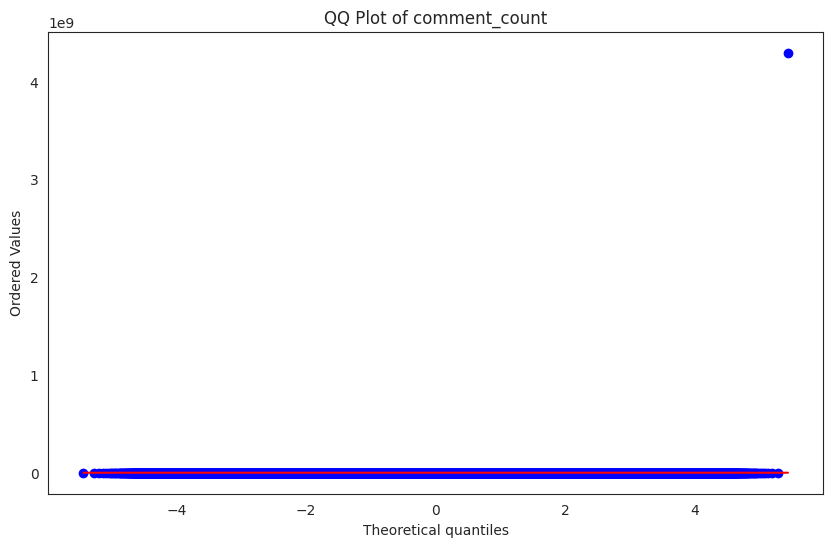

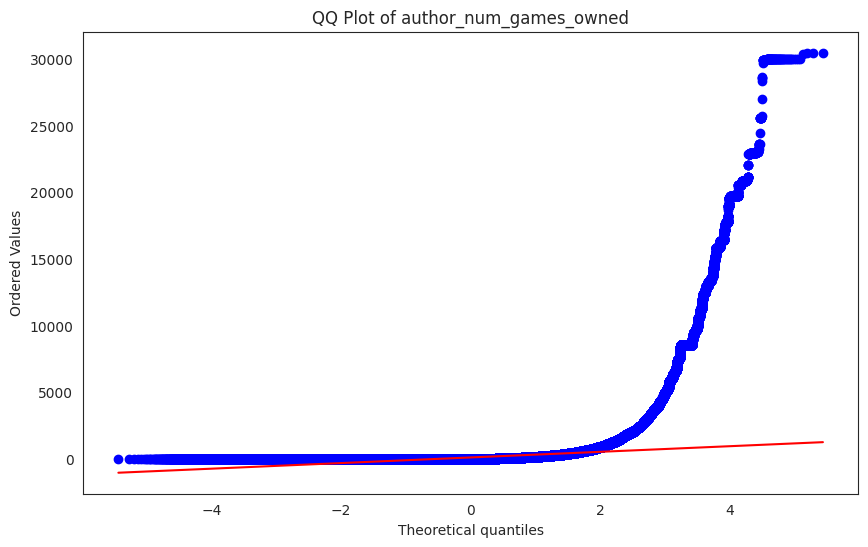

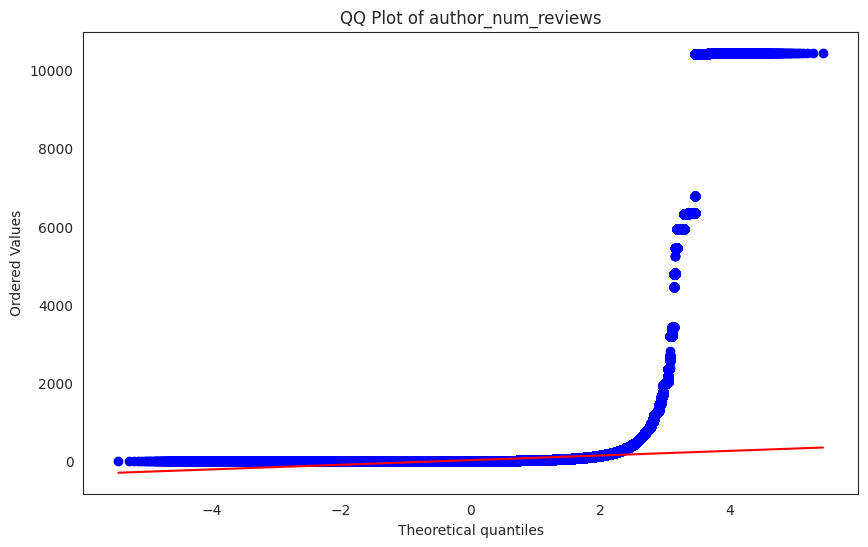

In [ ]:
# using Box-Cox to identify how to transform each individual variable
# Creating the list of our interaction terms which are not boolean values
interaction_terms = ['author_playtime_last_two_weeks', 'author_playtime_at_review', 'votes_up',
        'votes_funny', 'weighted_vote_score', 'comment_count',
        'author_num_games_owned', 'author_num_reviews']

# creating qq plots
for term in interaction_terms:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot()
    prob = stats.probplot(df[term], plot=ax)
    ax.set_title(f'QQ Plot of {term}')
    plt.show()

0.09267581975780242
0.10544700774694386


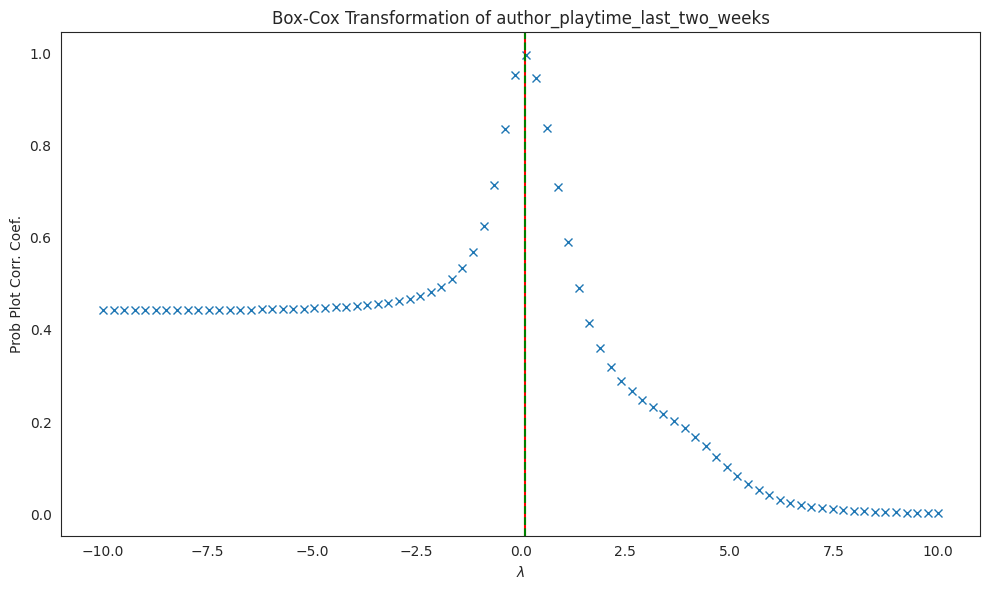

-0.012760929446476372
-0.011238403649650766


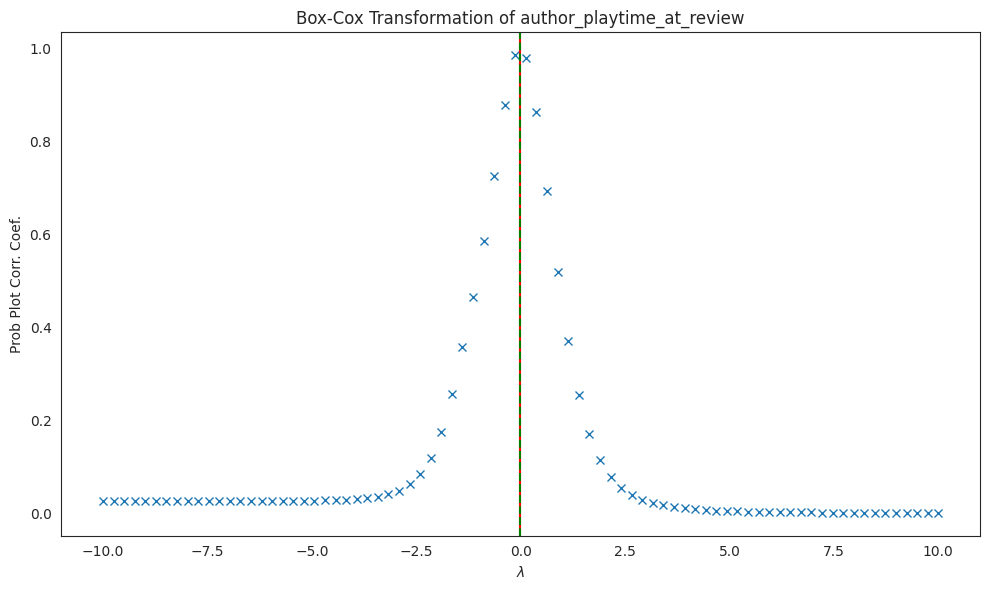

-0.8627632818670999
-0.49367917693424185


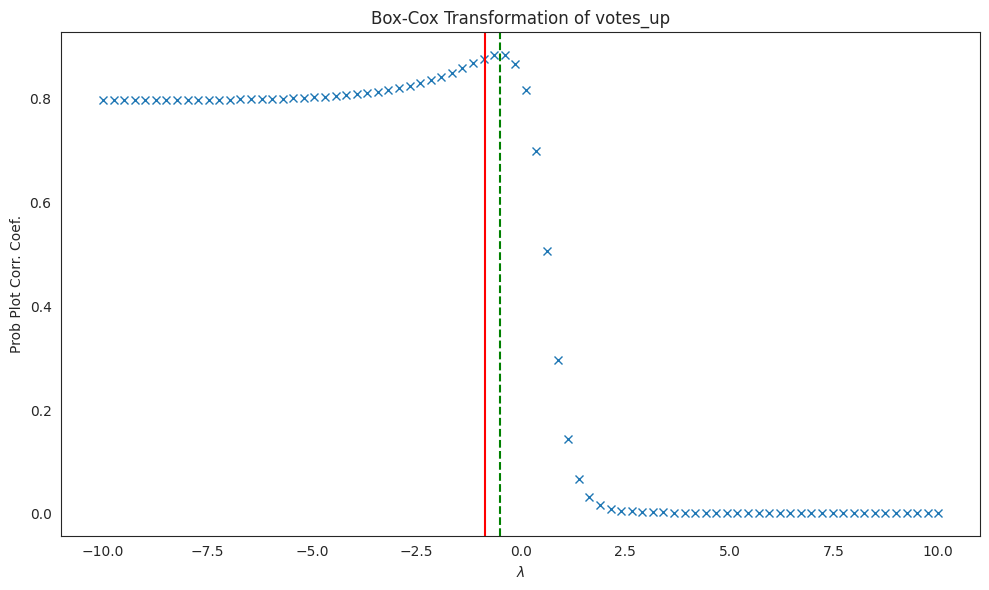

-1.2877888282156649
-0.6341615394253547


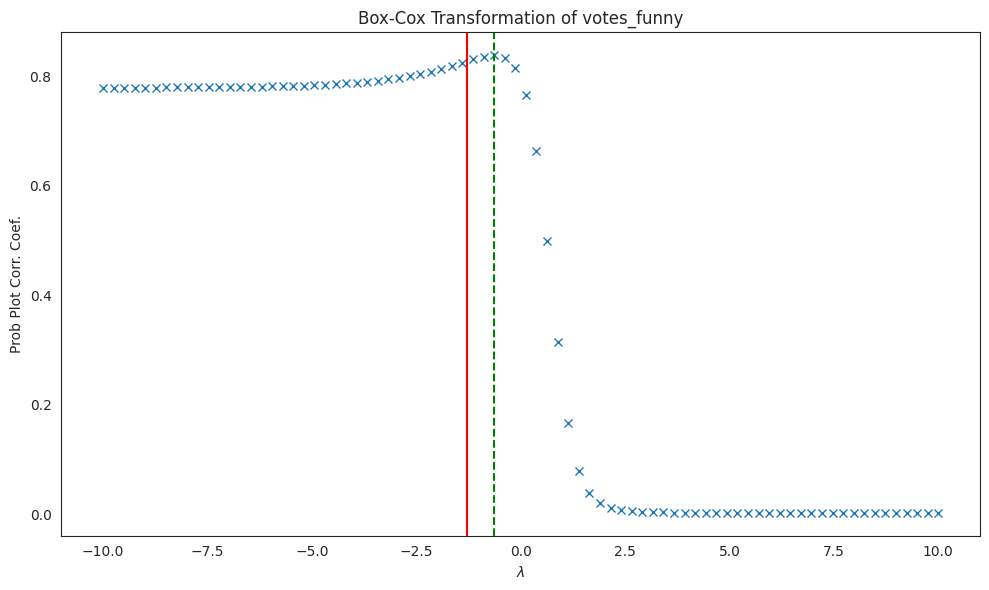

0.5424637201570691
0.6127231550740544


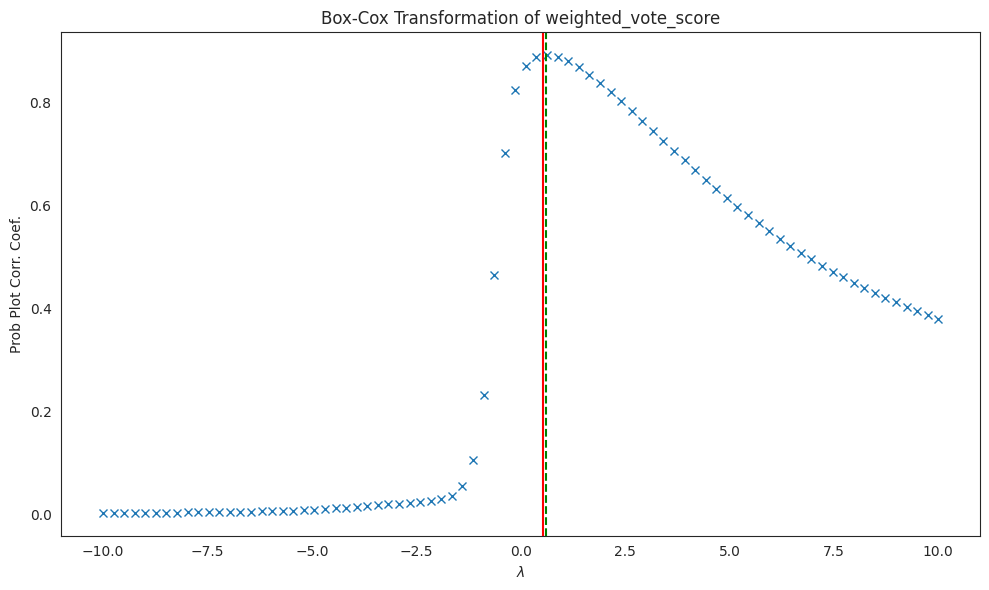

-1.3197836538773826
-0.5010596575943134


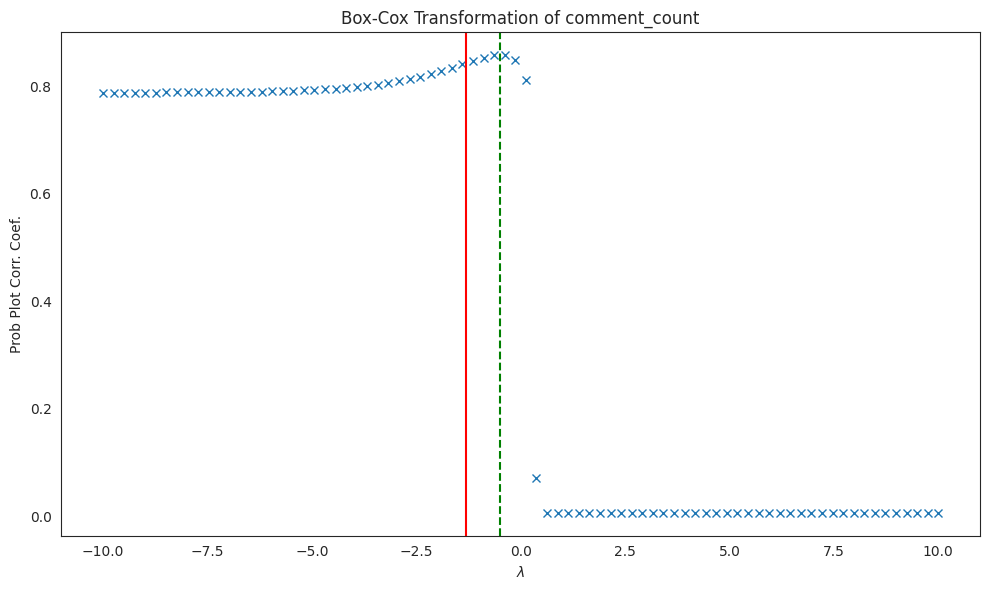

0.036150629127252365
0.03678465644780869


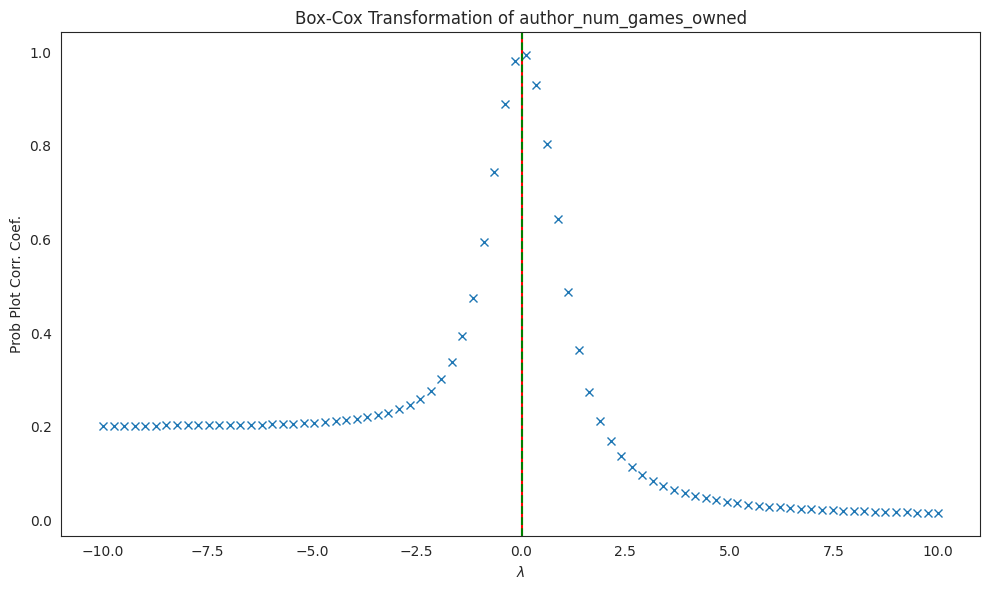

-0.15068857942834984
-0.1115401056936512


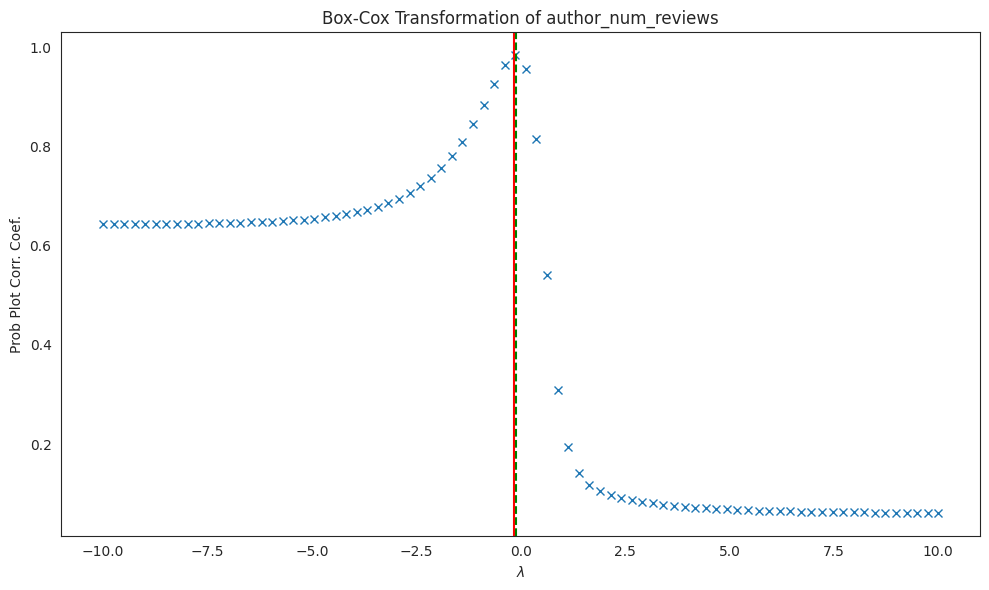

In [ ]:
# plot boxcox normmax
for term in interaction_terms:
    positive_data = df[term][df[term] > 0]
    if len(positive_data) == 0:
        print(f"Skipping {term} due to no positive values.")
        continue # Skip to next term if no positive values

    y, lmax_mle = stats.boxcox(positive_data)
    lmax_pearsonr = stats.boxcox_normmax(positive_data)
    print(lmax_mle)
    print(lmax_pearsonr)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot()
    prob = stats.boxcox_normplot(positive_data, -10, 10, plot=ax)
    ax.axvline(lmax_mle, color='r')
    ax.axvline(lmax_pearsonr, color='g', ls='--')
    ax.set_title(f'Box-Cox Transformation of {term}')
    plt.tight_layout()
    plt.show()

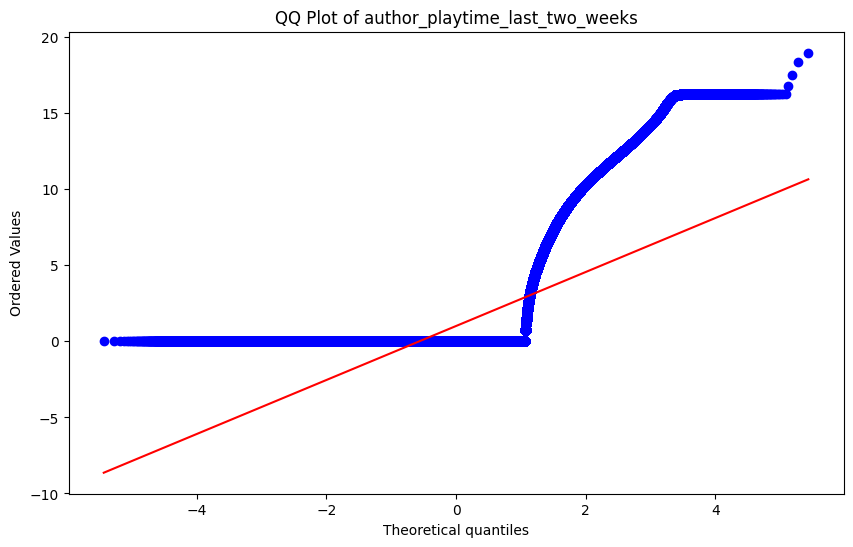

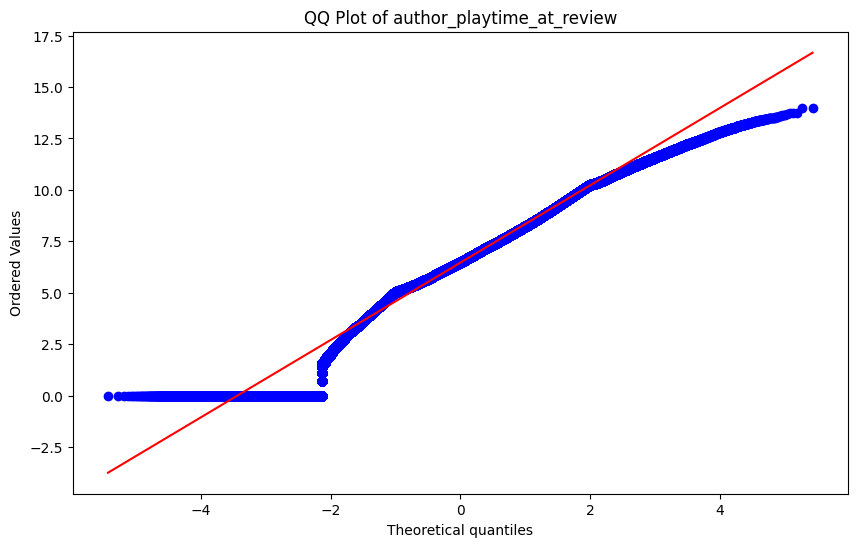

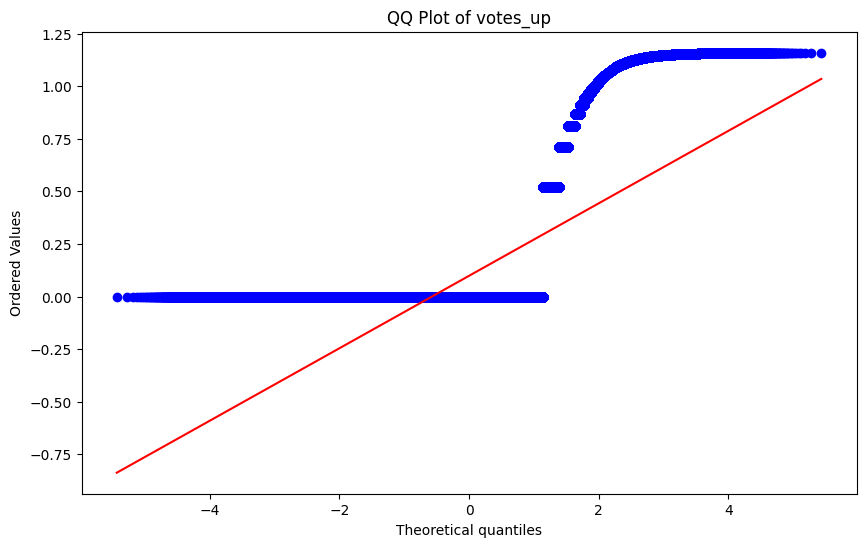

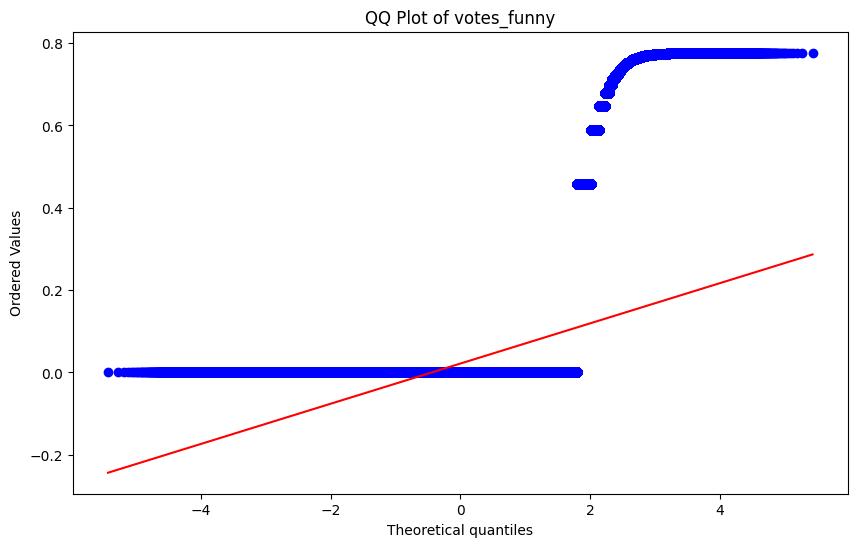

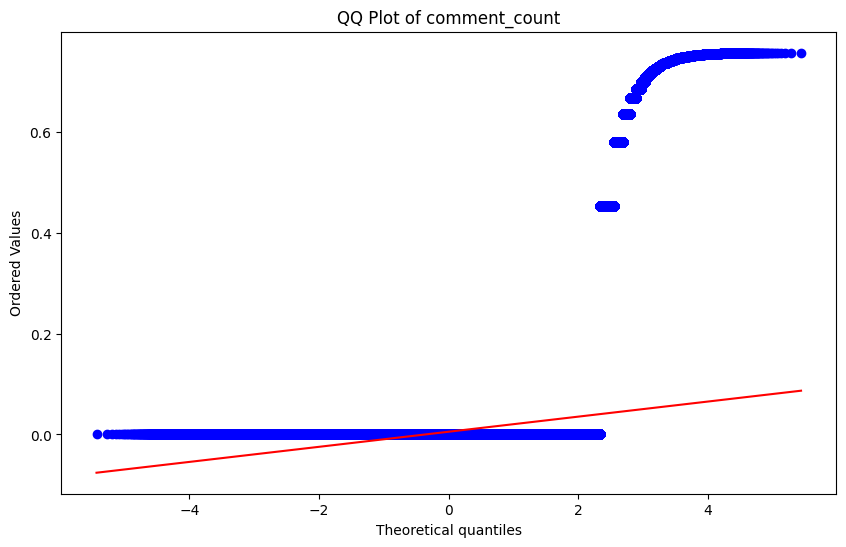

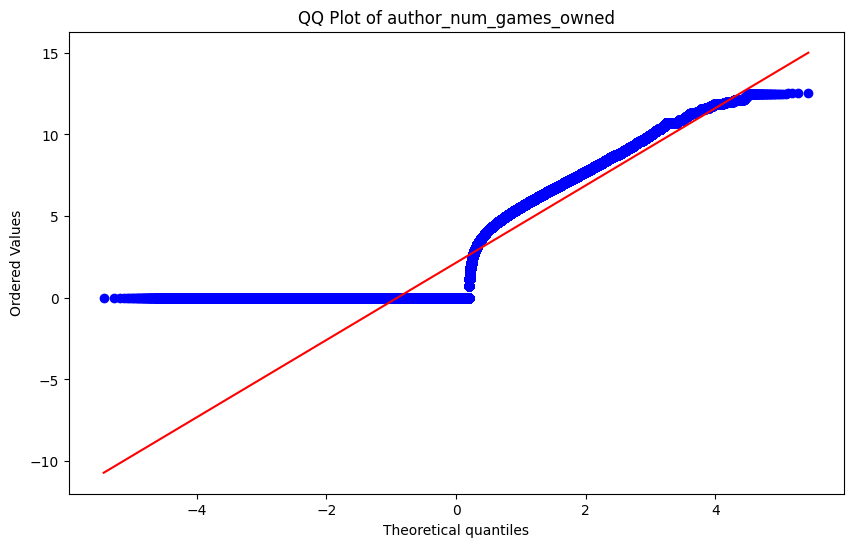

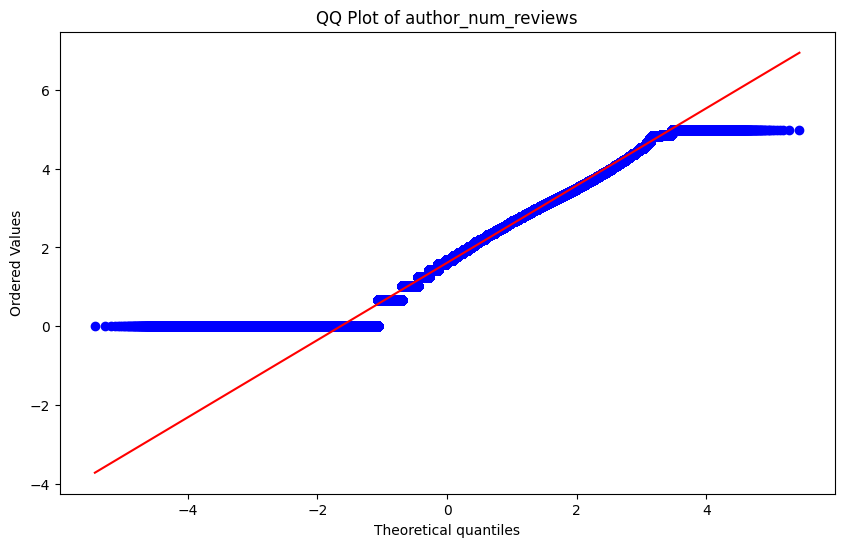

In [ ]:
# copying columns which need to be transformed
copy_df = df[['author_playtime_last_two_weeks', 'author_playtime_at_review',
        'votes_up', 'votes_funny', 'comment_count', 'author_num_games_owned',
        'author_num_reviews']].copy().astype(float)

for term in copy_df.columns:
    positive_data = copy_df[term][copy_df[term] > 0]
    if len(positive_data) == 0:
        print(f"Skipping {term} due to no positive values.")
        continue # Skip to next term if no positive values
    copy_df.loc[copy_df[term] > 0, term] = stats.boxcox(positive_data)[0]

    # plotting the qq plot of the transformation
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot()
    prob = stats.probplot(copy_df[term], plot=ax)
    ax.set_title(f'QQ Plot of {term}')
    plt.show()

## 2.3 Plot Results and Discussion



In [ ]:
interaction_df.describe()

voted_up  weighted_vote_score  steam_purchase  received_for_free  \
count  2.514465e+07         2.514465e+07    2.514465e+07       2.514465e+07   
mean   8.648132e-01         1.585927e-01    6.787105e-01       4.137286e-02   
std    3.419229e-01         2.420077e-01    4.669717e-01       1.991511e-01   
min    0.000000e+00         0.000000e+00    0.000000e+00       0.000000e+00   
25%    1.000000e+00         0.000000e+00    0.000000e+00       0.000000e+00   
50%    1.000000e+00         0.000000e+00    1.000000e+00       0.000000e+00   
75%    1.000000e+00         4.761905e-01    1.000000e+00       0.000000e+00   
max    1.000000e+00         9.919636e-01    1.000000e+00       1.000000e+00   

       written_during_early_access  author_playtime_last_two_weeks  \
count                 2.514465e+07                    2.514465e+07   
mean                  1.175387e-01                    1.007399e+00   
std                   3.220611e-01                    2.729033e+00   
min                   0.000000e+00                    0.000000e+00   
25%                   0.000000e+00                    0.000000e+00   
50%                   0.000000e+00                    0.000000e+00   
75%                   0.000000e+00                    0.000000e+00   
max                   1.000000e+00                    1.896812e+01   

       author_playtime_at_review      votes_up   votes_funny  comment_count  \
count               2.514465e+07  2.514465e+07  2.514465e+07   2.514465e+07   
mean                6.457612e+00  9.862175e-02  2.162118e-02   5.496396e-03   
std                 1.902701e+00  2.689523e-01  1.135833e-01   5.627921e-02   
min                 0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%                 5.416813e+00  0.000000e+00  0.000000e+00   0.000000e+00   
50%                 6.473820e+00  0.000000e+00  0.000000e+00   0.000000e+00   
75%                 7.632064e+00  0.000000e+00  0.000000e+00   0.000000e+00   
max                 1.398182e+01  1.158982e+00  7.765231e-01   7.576999e-01   

       author_num_games_owned  author_num_reviews  
count            2.514465e+07        2.514465e+07  
mean             2.146050e+00        1.611804e+00  
std              2.726354e+00        9.977980e-01  
min              0.000000e+00        0.000000e+00  
25%              0.000000e+00        1.012493e+00  
50%              0.000000e+00        1.686570e+00  
75%              4.718539e+00        2.343168e+00  
max              1.251500e+01        4.990658e+00

# 3 Baseline Model with SVD

The data is now ready for the first recommender type of recommender system, using Singular Value Decomposition (SVD). As an overview, the SVD method takes a utility matrix containing users, items, and their ratings and decomposes them into matrices $U$, $\Sigma$, and $V^T$.

$$ A \approx U\Sigma V^T$$

where

$$ U = \text{User feature matrix of left singular vectors}$$
$$ \Sigma = \text{Diagonal matrix of singular values}$$
$$ V^T = \text{Item feature matrix of right singular vectors}$$

However for this method to work, we need to have a way of expressing the "ratings" for each of the games. As the dataset currently, this means taking 12 factors and effectively condensing them into a singular representation in order for the SVD method to work.

I have 4 proposed methods of approaching this problem:


1.   Using Principle Component Analysis for dimensionality reduction
2.   KMeans Clustering
3.   Using an Autoencoder
4.   Manually assigning weights and linearly combining all the factors

Each of these methods has their own merits. With PCA and KMeans we intend to create latent representations through the use of clustering and creating a single "component" that best explains most of the variation in the errors.

With an autoencoder approach, we create a very simple network using Tensorflow + Keras to implement an encoder/decoder network and are again creating a single dimensional output, the ratings, which will be the learned representations of the 12 variables.

Once these terms are created, I then normalize their values to exist on a 1-5 scale. This is done moreso for human readability, as later inspection of rating values will make more sense.

Finally, we add a penalization term to all ratings based on the relative "popularity" of the game. This is based on the total number of reviews a game has recieved. The reason for this is two fold. First, this ensures that games that might have few, all positive reviews will not float to the top of the ratings and always be recommended. Second, this penalization also acts a confidence measure of how sure we are that a particular game is in fact well liked by the general population. A game with a few dozen good reviews might be good for individuals who like a particular niche whereas a game with over 1000 reviews that are mostly positive is likely to be enjoyed by a far larger audience and, therefore, can be safer to recommend.

## 3.1 Creating The Latent Representation





Starting by creating a single dataframe that holds only the interaction terms and the user/game ids.

In [ ]:
# creating the interaction df
interaction_df = df[['voted_up', 'weighted_vote_score', 'steam_purchase', 'received_for_free', 'written_during_early_access']]

# adding scaled terms
for term in copy_df.columns:
    interaction_df[term] = copy_df.loc[:, term]


interaction_df['voted_up'] = interaction_df['voted_up'].astype(int)
interaction_df['steam_purchase'] = interaction_df['steam_purchase'].astype(int)
interaction_df['received_for_free'] = interaction_df['received_for_free'].astype(int)
interaction_df['written_during_early_access'] = interaction_df['written_during_early_access'].astype(int)

interaction_df.head()

<ipython-input-18-d8e211142848>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_df[term] = copy_df.loc[:, term]
<ipython-input-18-d8e211142848>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_df[term] = copy_df.loc[:, term]
<ipython-input-18-d8e211142848>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

voted_up  weighted_vote_score  steam_purchase  received_for_free  \
0         1              0.00000               1                  0   
1         1              0.00000               0                  0   
2         1              0.00000               0                  0   
3         1              0.00000               1                  0   
4         1              0.52381               1                  0   

   written_during_early_access  author_playtime_last_two_weeks  \
0                            0                        4.432677   
1                            0                        0.000000   
2                            0                        1.156487   
3                            0                        0.000000   
4                            0                        6.840961   

   author_playtime_at_review  votes_up  votes_funny  comment_count  \
0                   5.109046       0.0          0.0            0.0   
1                   8.859469       0.0          0.0            0.0   
2                   9.964656       0.0          0.0            0.0   
3                   3.328444       0.0          0.0            0.0   
4                   5.164301       0.0          0.0            0.0   

   author_num_games_owned  author_num_reviews  
0                0.000000            0.658176  
1                4.575341            0.000000  
2                0.000000            1.429140  
3                4.608657            2.735496  
4                1.657180            1.570250

In [ ]:
# Adding identifiers like users, items, and game titles
interaction_df['appid'] = df['appid']
interaction_df['author_steamid'] = df['author_steamid']
interaction_df['game'] = df['game']

<ipython-input-10-7300282ff6be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_df['appid'] = df['appid']
<ipython-input-10-7300282ff6be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_df['author_steamid'] = df['author_steamid']
<ipython-input-10-7300282ff6be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
df.head()

voted_up  weighted_vote_score  steam_purchase  received_for_free  \
0         1              0.00000               1                  0   
1         1              0.00000               0                  0   
2         1              0.00000               0                  0   
3         1              0.00000               1                  0   
4         1              0.52381               1                  0   

   written_during_early_access  author_playtime_last_two_weeks  \
0                            0                        4.432677   
1                            0                        0.000000   
2                            0                        1.156487   
3                            0                        0.000000   
4                            0                        6.840961   

   author_playtime_at_review  votes_up  votes_funny  comment_count  \
0                   5.109046       0.0          0.0            0.0   
1                   8.859469       0.0          0.0            0.0   
2                   9.964656       0.0          0.0            0.0   
3                   3.328444       0.0          0.0            0.0   
4                   5.164301       0.0          0.0            0.0   

   author_num_games_owned  author_num_reviews  appid     author_steamid  \
0                0.000000            0.658176     10  76561198363716816   
1                4.575341            0.000000     10  76561198134752176   
2                0.000000            1.429140     10  76561197985437504   
3                4.608657            2.735496     10  76561199015747392   
4                1.657180            1.570250     10  76561199479067344   

             game  
0  Counter-Strike  
1  Counter-Strike  
2  Counter-Strike  
3  Counter-Strike  
4  Counter-Strike

In [ ]:
# creating a new feature, which contains the total amount of reviews for the game
# start here with scaled data
df['total_reviews'] = df.groupby('appid')['appid'].transform('count')
df['total_upvotes'] = df.groupby('appid')['voted_up'].transform('sum')
df['ratio'] = df['total_upvotes'] / df['total_reviews']

### 3.1.1 PCA Dimension Reduction

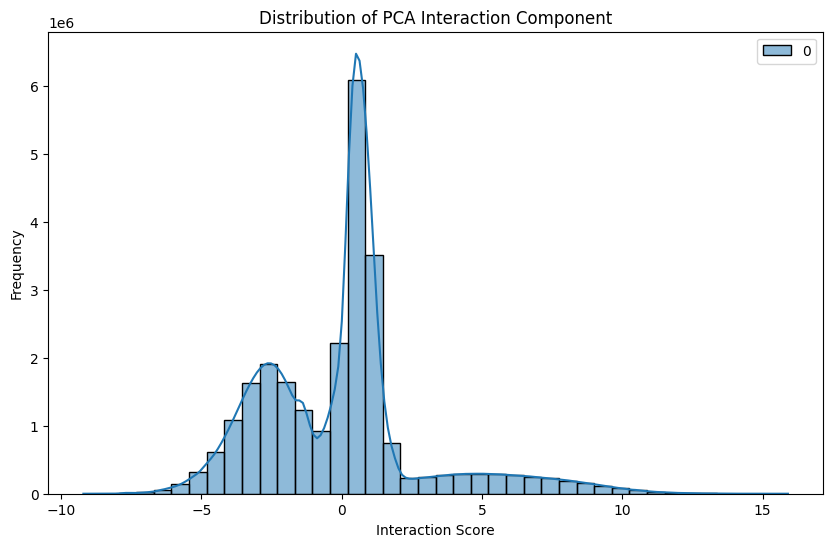

In [ ]:
interaction_terms = ['author_playtime_last_two_weeks', 'author_playtime_at_review', 'votes_up',
        'voted_up', 'votes_funny', 'weighted_vote_score', 'steam_purchase',
        'received_for_free', 'written_during_early_access', 'comment_count',
        'author_num_games_owned', 'author_num_reviews']


# Using PCA to aggregate the interactions terms into a single value for the SVD
pca = PCA(n_components=1)
principal_components = pca.fit_transform(df[interaction_terms])
df['pca_rating'] = principal_components


# Visualize the interaction component
plt.figure(figsize=(10, 6))
sns.histplot(principal_components, bins=40, kde=True)
plt.title('Distribution of PCA Interaction Component')
plt.xlabel('Interaction Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Normalize to 1-5 scale
df['pca_rating'] = 1 + (df['pca_rating'] - df['pca_rating'].min()) / (df['pca_rating'].max() - df['pca_rating'].min()) * 4

# Apply penalization based on review count
# given that there isn't enough data we don't want to blindly recommend an
# unknown game to someone who is not deliberately in the market for it
def apply_penalization(row, rating_column):
    if row['total_reviews'] < 250:
        return row[rating_column] * 0.5  # High penalization
    elif row['total_reviews'] < 500:
        return row[rating_column] * 0.75  # Moderate penalization
    elif row['total_reviews'] < 1000:
        return row[rating_column] * 0.9  # Slight penalization
    else:
        return row[rating_column]  # No penalization

df['pca_rating'] = df.apply(lambda row: apply_penalization(row, 'pca_rating'), axis=1)

# re-normalizing after the penalization step
df['pca_rating'] = 1 + (df['pca_rating'] - df['pca_rating'].min()) / (df['pca_rating'].max() - df['pca_rating'].min()) * 4

### 3.1.2 KMeans Dimension Reduction

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=108)
cluster_labels = kmeans.fit_predict(df[interaction_terms])

# Calculate distances to cluster centroids
distances = kmeans.transform(df[interaction_terms])

# Assign ratings based on inverse distance to centroids
df['kmeans_rating'] = 5 - distances.min(axis=1)

# Normalize to 1-5 scale
df['kmeans_rating'] = 1 + (df['kmeans_rating'] - df['kmeans_rating'].min()) / (df['kmeans_rating'].max() - df['kmeans_rating'].min()) * 4

df['kmeans_rating'] = df.apply(lambda row: apply_penalization(row, 'kmeans_rating'), axis=1)

# renormalize
df['kmeans_rating'] = 1 + (df['kmeans_rating'] - df['kmeans_rating'].min()) / (df['kmeans_rating'].max() - df['kmeans_rating'].min()) * 4

df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


voted_up  weighted_vote_score  steam_purchase  received_for_free  \
0         1                0.000               1                  0   
1         1                0.000               0                  0   
2         1                0.000               0                  0   
3         1                0.000               1                  0   
4         1                0.524               1                  0   

   written_during_early_access  author_playtime_last_two_weeks  \
0                            0                           4.433   
1                            0                           0.000   
2                            0                           1.156   
3                            0                           0.000   
4                            0                           6.841   

   author_playtime_at_review  votes_up  votes_funny  comment_count  \
0                      5.109     0.000        0.000          0.000   
1                      8.859     0.000        0.000          0.000   
2                      9.965     0.000        0.000          0.000   
3                      3.328     0.000        0.000          0.000   
4                      5.164     0.000        0.000          0.000   

   author_num_games_owned  author_num_reviews  appid     author_steamid  \
0                   0.000               0.658     10  76561198363716816   
1                   4.575               0.000     10  76561198134752176   
2                   0.000               1.429     10  76561197985437504   
3                   4.609               2.735     10  76561199015747392   
4                   1.657               1.570     10  76561199479067344   

             game  total_reviews  total_upvotes  ratio  pca_rating  \
0  Counter-Strike          11613          11268  0.970       3.250   
1  Counter-Strike          11613          11268  0.970       2.566   
2  Counter-Strike          11613          11268  0.970       3.096   
3  Counter-Strike          11613          11268  0.970       2.283   
4  Counter-Strike          11613          11268  0.970       3.336   

   kmeans_rating  
0          3.890  
1          4.407  
2          4.390  
3          4.559  
4          4.263

### 3.1.3 Autoencoder Dimension Reduction

In [ ]:
# Define autoencoder
input_dim = df[interaction_terms].shape[1]
encoding_dim = 1

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(df[interaction_terms], df[interaction_terms], epochs=20, batch_size=4096, shuffle=True, verbose=1)

# Get encoded values as ratings
df['autoencoder_rating'] = encoder.predict(df[interaction_terms])

# Normalize to 1-5 scale
df['autoencoder_rating'] = 1 + (df['autoencoder_rating'] - df['autoencoder_rating'].min()) / (df['autoencoder_rating'].max() - df['autoencoder_rating'].min()) * 4

df['autoencoder_rating'] = df.apply(lambda row: apply_penalization(row, 'autoencoder_rating'), axis=1)

# renormalize
df['autoencoder_rating'] = 1 + (df['autoencoder_rating'] - df['autoencoder_rating'].min()) / (df['autoencoder_rating'].max() - df['autoencoder_rating'].min()) * 4

df.head()

Epoch 1/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 1.7744
Epoch 2/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.0697
Epoch 3/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9809
Epoch 4/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9755
Epoch 5/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9756
Epoch 6/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9757
Epoch 7/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9755
Epoch 8/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9751
Epoch 9/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9754
Epoch 10/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9758
Epoch 11/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9754
Epoch 12/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9752
Epoch 13/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9753
Epoch 14/20
6139/6139 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9755
Epoch 15/20
6139/6139 ━━━━━━

voted_up  weighted_vote_score  steam_purchase  received_for_free  \
0         1                0.000               1                  0   
1         1                0.000               0                  0   
2         1                0.000               0                  0   
3         1                0.000               1                  0   
4         1                0.524               1                  0   

   written_during_early_access  author_playtime_last_two_weeks  \
0                            0                           4.433   
1                            0                           0.000   
2                            0                           1.156   
3                            0                           0.000   
4                            0                           6.841   

   author_playtime_at_review  votes_up  votes_funny  comment_count  ...  \
0                      5.109     0.000        0.000          0.000  ...   
1                      8.859     0.000        0.000          0.000  ...   
2                      9.965     0.000        0.000          0.000  ...   
3                      3.328     0.000        0.000          0.000  ...   
4                      5.164     0.000        0.000          0.000  ...   

   author_num_reviews  appid     author_steamid            game total_reviews  \
0               0.658     10  76561198363716816  Counter-Strike         11613   
1               0.000     10  76561198134752176  Counter-Strike         11613   
2               1.429     10  76561197985437504  Counter-Strike         11613   
3               2.735     10  76561199015747392  Counter-Strike         11613   
4               1.570     10  76561199479067344  Counter-Strike         11613   

   total_upvotes  ratio  pca_rating  kmeans_rating  autoencoder_rating  
0          11268  0.970       3.250          3.890               3.109  
1          11268  0.970       2.566          4.407               2.369  
2          11268  0.970       3.096          4.390               2.942  
3          11268  0.970       2.283          4.559               2.064  
4          11268  0.970       3.336          4.263               3.202  

[5 rows x 21 columns]

### 3.1.4 Manual Dimension Reduction

In [ ]:
# Manual Rating

# First we define the inherent rating value
df['manual_rating'] = (
    df['voted_up'] +
    df['weighted_vote_score'] * 3 + # emphasize what steam believes to be a good review
    df['author_playtime_at_review'] * 0.5 + # value highly overall interaction
    df['author_playtime_last_two_weeks'] * 0.2 + # moderately value recent interaction
    df['votes_up'] * 0.5 + # highly value community feedback
    df['votes_funny'] * 0.1 + # consideration for humor
    df['comment_count'] * 0.3 + # value comments
    df['author_num_games_owned'] * 0.1 +
    df['author_num_reviews'] * 0.1 +
    df['steam_purchase'] * 1.1 # emphasize reviews where the user is a purchaser
)

# # Normalize the rating to a 1-5 scale
df['manual_rating'] = 1 + (df['manual_rating'] - df['manual_rating'].min()) / (df['manual_rating'].max() - df['manual_rating'].min()) * 4

df['manual_rating'] = df.apply(lambda row: apply_penalization(row, 'manual_rating'), axis=1)

# renormalize
df['manual_rating'] = 1 + (df['manual_rating'] - df['manual_rating'].min()) / (df['manual_rating'].max() - df['manual_rating'].min()) * 4

df.head()

voted_up  weighted_vote_score  steam_purchase  received_for_free  \
0         1                0.000               1                  0   
1         1                0.000               0                  0   
2         1                0.000               0                  0   
3         1                0.000               1                  0   
4         1                0.524               1                  0   

   written_during_early_access  author_playtime_last_two_weeks  \
0                            0                           4.433   
1                            0                           0.000   
2                            0                           1.156   
3                            0                           0.000   
4                            0                           6.841   

   author_playtime_at_review  votes_up  votes_funny  comment_count  ...  \
0                      5.109     0.000        0.000          0.000  ...   
1                      8.859     0.000        0.000          0.000  ...   
2                      9.965     0.000        0.000          0.000  ...   
3                      3.328     0.000        0.000          0.000  ...   
4                      5.164     0.000        0.000          0.000  ...   

   appid     author_steamid            game  total_reviews total_upvotes  \
0     10  76561198363716816  Counter-Strike          11613         11268   
1     10  76561198134752176  Counter-Strike          11613         11268   
2     10  76561197985437504  Counter-Strike          11613         11268   
3     10  76561199015747392  Counter-Strike          11613         11268   
4     10  76561199479067344  Counter-Strike          11613         11268   

   ratio  pca_rating  kmeans_rating  autoencoder_rating  manual_rating  
0  0.970       3.250          3.890               3.109          2.681  
1  0.970       2.566          4.407               2.369          2.743  
2  0.970       3.096          4.390               2.942          2.846  
3  0.970       2.283          4.559               2.064          2.439  
4  0.970       3.336          4.263               3.202          3.194  

[5 rows x 22 columns]

## 3.2 Creating SVD Recommender w/ Surprise

With all of our interaction terms being used to create a single "rating" variable, we can see that there is quite the range of values which each method has assigned. KMeans shows signs of over inflating the rating of any review, whereas my own manual rating appears to under-value all the reviews. The PCA ratings appear to be the most balanced.

Now we can create several SVD models, each using one of the generated ratings, and compare their performance.

In [ ]:
# constructing SVD Recommender for each decomposition type
def svd_recommender(df, rating, n=10):

    print(f'\nSVD Recommender Utilizing {rating}')

    # Define a reader with the rating scale that we have scaled everything to
    reader = Reader(rating_scale=(1, 5))

    # Load the data into Surprise's Dataset
    data = Dataset.load_from_df(df[['author_steamid', 'appid', rating]], reader)

    # sample random trainset and testset
    # test set is made of 15% of the ratings.
    trainset, testset = train_test_split(data, test_size=0.15, random_state=108)

    # SVD algorithm.
    algo = SVD(n_factors=100, n_epochs=n, lr_all=0.005, reg_all=0.02)

    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    display(f'RMSE: {rmse}')
    display(f'MAE: {mae}')

    return algo

pca_recommender = svd_recommender(df, 'pca_rating')
kmeans_recommender = svd_recommender(df, 'kmeans_rating')
autoencoder_recommender = svd_recommender(df, 'autoencoder_rating')
manual_recommender = svd_recommender(df, 'manual_rating')


SVD Recommender Utilizing pca_rating
RMSE: 0.3489
MAE:  0.2590


'RMSE: 0.348921933551938'

'MAE: 0.259045452337689'


SVD Recommender Utilizing kmeans_rating
RMSE: 0.3062
MAE:  0.2178


'RMSE: 0.3062188205161278'

'MAE: 0.21784845999482538'


SVD Recommender Utilizing autoencoder_rating
RMSE: 0.3739
MAE:  0.2779


'RMSE: 0.37387899902157384'

'MAE: 0.2779067009193236'


SVD Recommender Utilizing manual_rating
RMSE: 0.2925
MAE:  0.2210


'RMSE: 0.29246851736648166'

'MAE: 0.22096106551548478'

In [ ]:
def get_top_n_recommendations(model, user_id, n=10):
    # Get all items
    all_items = df['appid'].unique()

    # Get items the user hasn't interacted with
    user_items = df[df['author_steamid'] == user_id]['appid']
    items_to_predict = list(set(all_items) - set(user_items))

    # Make predictions
    predictions = [model.predict(user_id, item) for item in items_to_predict]

    # Sort predictions by estimated rating
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return [(pred.iid, pred.est) for pred in top_n]

# getting a random user
user_id = random.choice(df['author_steamid'].unique())

# Getting items they have reviewed
recommendations = get_top_n_recommendations(pca_recommender, user_id)

print(f"\nSVD w/ PCA - Top 10 recommendations for user {user_id}:")

for app_id, estimated_rating in recommendations:
    print(f"App ID: {app_id}, Game Name: {df.loc[df['appid'] == app_id, 'game'].unique()[0]}, Estimated Rating: {estimated_rating}")

# Getting items they have reviewed
recommendations = get_top_n_recommendations(kmeans_recommender, user_id)

print(f"\nSVD w/ KMeans - Top 10 recommendations for user {user_id}:")

for app_id, estimated_rating in recommendations:
    print(f"App ID: {app_id}, Game Name: {df.loc[df['appid'] == app_id, 'game'].unique()[0]}, Estimated Rating: {estimated_rating}")

# Getting items they have reviewed
recommendations = get_top_n_recommendations(autoencoder_recommender, user_id)

print(f"\nSVD w/ Autoencoder - Top 10 recommendations for user {user_id}:")

for app_id, estimated_rating in recommendations:
    print(f"App ID: {app_id}, Game Name: {df.loc[df['appid'] == app_id, 'game'].unique()[0]}, Estimated Rating: {estimated_rating}")

# Getting items they have reviewed
recommendations = get_top_n_recommendations(manual_recommender, user_id)

print(f"\nSVD w/ Manual - Top 10 recommendations for user {user_id}:")

for app_id, estimated_rating in recommendations:
    print(f"App ID: {app_id}, Game Name: {df.loc[df['appid'] == app_id, 'game'].unique()[0]}, Estimated Rating: {estimated_rating}")



SVD w/ PCA - Top 10 recommendations for user 76561198798175056:
App ID: 2344520, Game Name: Diablo® IV, Estimated Rating: 3.7788053988900097
App ID: 2195250, Game Name: EA SPORTS FC™ 24, Estimated Rating: 3.777800732534162
App ID: 949230, Game Name: Cities: Skylines II, Estimated Rating: 3.623160663590868
App ID: 1501750, Game Name: Lords of the Fallen, Estimated Rating: 3.5924790918202416
App ID: 2285150, Game Name: The Front, Estimated Rating: 3.575064413973061
App ID: 1989270, Game Name: Slay the Princess, Estimated Rating: 3.539342859033443
App ID: 2440510, Game Name: Forza Motorsport, Estimated Rating: 3.4658979804606918
App ID: 1009850, Game Name: OVR Advanced Settings, Estimated Rating: 3.4635363339705756
App ID: 1966720, Game Name: Lethal Company, Estimated Rating: 3.4375405734420896
App ID: 1937780, Game Name: Total War: PHARAOH, Estimated Rating: 3.4229054764359974

SVD w/ KMeans - Top 10 recommendations for user 76561198798175056:
App ID: 237990, Game Name: The Banner Saga,

In [ ]:
# Viewing which titles this particular user has reviewed
df[df['author_steamid'] == user_id]['game']

7608714                       PAYDAY 3
38561226            Deep Rock Galactic
44463874              Counter-Strike 2
48300739    Sekiro™: Shadows Die Twice
Name: game, dtype: string

## 3.3 SVD Conclusions

Initial results show remarkably low RMSE and MAE values, ranging from 0.29 to 0.37 for RMSE and 0.21 to 0.27 for MAE, to the point where I am suspect that these values do not represent the true performance of the SVD recommender. There is some variability between the performance metrics, with some aggregation methods yielding marginally better results than others. In order to better understand what might be occuring, we must make actual recommendations using the various SVD recommenders.

For the recommendations, we choose a random user from the dataset and see what types of games each method would recommend, as well as an estimated rating that we believe the user would give.

Most notable here is the fact that all of these recommenders are fairly consistent between each other, with certain games like "Diablo IV"  and "EA SPORTS FC 24" showing high on the recommended list for 3 of the four methods. The SVD recommender using the KMeans representation is most different from the other three recommenders. Looking at the estimated rating scores, we can begin to hypothesize as to why. The KMeans method appears to have created many inflated rating scores, with all the recommended titles having an estimated rating ranging from 4.74 to 4.76.

But do these recommendations even make sense? Inspecting which games the random user has previously reviewed, we can see that they appear to enjoy First-Person Shooter (FPS) games and adventure games. With this in mind, the recommendations that have been made only somewhat make sense, lending further evidence that the low RMSE and MAE scores are not indicative of actual performance. I find that the recommender system suggests a wider variety of game genres, some of which might not be of particular interest to this user.

This is indicative of underlying problems with this model. In some ways, this was to be expected. Taking 12 variables, creating a combined representation of them, then taking the latent features of that combination will inevitably lead to information loss.

However, the variable compression must occur for this particular method to work. We can only pass the users, the items, and a single ratings value into SVD. While this is a valiant first effort, I recognize that there are many shortcomings. As such we must look to other methods to perhaps improve on the SVD recommender.

# 4 Graph Based Recommender with NetworkX

Here I attempt to create and evaluate a bipartite graph network utilizing the NetworkX package. A bipartite graph is chosen as the nature of the data lends itself to being split into users, items, and the edges being the aggregated "rating" score.

In the interest of time and available computational resources, the data is scaled back to only 10% of the total data, 2,514,465 total reviews. Initial attempts at using the full 25 million reviews resulted in computation times that exceeded 10+ hours and often times failed to provide a result.

Implemented here is an item-item collaborative filtering graph based recommender. For predictions, I use a weighted sum, referenced from Carleton College [6], as is described as follows:

$$ P_{u, i} = \frac{\sum_\text{all similar items, N}(s_{i, N} \times R_{u, N})}{\sum_\text{all similar items, N}(|s_{i,N}|)} $$

Where "we weight the user's rating for each of these items by the similarity between that and the target item."

In [ ]:
# reduce the dataset again to only include 1/10 of the total data
df = df.sample(frac=0.1, random_state=108)
df.shape

(2514465, 22)

In [ ]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=108)

# Setting up the bipartite graph
Graph_pca = nx.Graph()
Graph_pca.add_nodes_from(train_df['author_steamid'], bipartite=0)  # Users
Graph_pca.add_nodes_from(train_df['appid'], bipartite=1)  # Items

# adding the edges using the pca_rating
edges = list(zip(train_df['author_steamid'], train_df['appid'], train_df['pca_rating']))
Graph_pca.add_weighted_edges_from(edges)

# Project the bipartite graph onto the item nodes
item_nodes = set(n for n, d in Graph_pca.nodes(data=True) if d['bipartite'] == 1)
item_graph = bipartite.weighted_projected_graph(Graph_pca, item_nodes)

# Using item-item similarity
def predict_rating(user, item, item_graph, B):

    # No prediction possible, issue with elements that are not present within the graph
    if item not in item_graph:
        return np.nan

    # Get neighbors of the item
    neighbors = item_graph[item]
    total_weight = 0
    weighted_sum = 0

    # For each neighbor we want to calculate the total weight of the connection
    for neighbor in neighbors:
        if user in B.neighbors(neighbor):
            weight = item_graph[item][neighbor]['weight']
            rating = B[user][neighbor]['weight']
            weighted_sum += weight * rating
            total_weight += weight

    # If there are no neighbors, there is no connection
    if total_weight == 0:
        return np.nan  # No prediction possible
    return weighted_sum / total_weight

# generate predictions for the test set, probably not efficient
test_df['predicted_ratings'] = test_df.apply(lambda row: predict_rating(row['author_steamid'], row['appid'], item_graph, Graph_pca), axis=1)

# drop rows where prediction is not possible, division by 0 is bad
test_df = test_df.dropna(subset=['predicted_ratings'])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df['ratings'], test_df['predicted_ratings']))
print(f'RMSE: {rmse}')

# recommend similar items for a given single item
def recommend_similar_items(item, item_graph, top_n=10):

    # simply find all the neighbors of a given item
    neighbors = item_graph[item]

    # sort the neighbors, take only the top ten items, then return them
    similar_items = sorted(neighbors.items(), key=lambda x: x[1]['weight'], reverse=True)[:top_n]
    return [item for item, _ in similar_items]

# recommend top 10 items for a user
def recommend_items(user, item_graph, B, top_n=10):

    # Storing our recommendations as a dictionary
    recommendations = {}

    # Checking which items are neighboring the user
    for item in item_nodes:
        if item not in B.neighbors(user):

            # Predict the rating for the item
            predicted_rating = predict_rating(user, item, item_graph, B)
            if not np.isnan(predicted_rating):
                recommendations[item] = predicted_rating

    # Sort recommendations by predicted rating and returning the top 10
    recommended_items = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [item for item, _ in recommended_items]

# Select a random user from the dataset
random_user = random.choice(df['author_steamid'].unique())

# Get top 10 similar items to a given item
item = 10
game_name = df[df['appid'] == item]['game'].iloc[0]
top_10_similar_items = recommend_similar_items(item, item_graph, top_n=10)
print(f'Top 10 similar items to {item}, {game_name}: ')
for item in top_10_similar_items:
    game_name = df[df['appid'] == item]['game'].iloc[0]
    print(f'{game_name}')

# Get top 10 recommendations for the random user
top_10_recommendations = recommend_items(random_user, item_graph, Graph_pca, top_n=10)
print(f'\nTop 10 recommendations for user {random_user}: ')
for item in top_10_recommendations:
    game_name = df[df['appid'] == item]['game'].iloc[0]
    print(f'{game_name}')

print(f'\nGames reviewed by {random_user}:')
df[df['author_steamid'] == random_user]['game']



Top 10 similar items to 10, Counter-Strike: 
Counter-Strike 2
Counter-Strike: Source
Left 4 Dead 2
Grand Theft Auto V
Portal 2
Apex Legends
Counter-Strike: Condition Zero
Among Us
PAYDAY 2
Battlefield™ 2042

Top 10 recommendations for user 76561198060840560: 
Super Man Or Monster
Don't Bite Me Bro! +
Ricochet
Half-Life: Blue Shift
Spiritfall
Half-Life: Source
Half-Life 2: Deathmatch
Asura: Vengeance Edition
Left 4 Dead
三国杀

Games reviewed by 76561198060840560:


41882221             Risk of Rain 2
39076344    Warhammer: Vermintide 2
Name: game, dtype: string

## 4.2 Graph Based Recommender Results

Unfortunately, I was unable to achieve an acceptable resulting using this method.

Initial problems arose when trying to utilize the full data 25 milion row dataset, often resulting in runtime timeouts or crashes. A remediation step of reducing the total data to only 1/10th of the original  dataset was taken, and the network was able to be completed afterwords.

Next is the issue of attempting to quantify the RMSE of the graph network. This particular calculation proved to extend for hours with no end in sight. I am unsure as to why this is the case, but I suspect that there are issues with trying to evaluate the graph network on items that do not exist within it (from the test set) or perhaps I am using an inneficient method.

Finally I was unable to test using the other aggregated rating values due to a lack of time from troubleshooting the existing methods I had.

The only result I was able to achieve was to retrieve the top items which were similar to a given item, which appears to work well, and the top items which are recommended for a particular user, which also appears to work well. However it must be noted that there is no meaningful metric to backup my claims for this, only industry knowledge and insights.

# 5 Conclusion

In conclusion, these recommender systems still require much work before they could be even considered passable. While the SVD recommenders were able to produce consistent results, they remain inflexible and highly reliant on the "rating" representation between the users and the items. I suspect that the choice to stick with the SVD method was not wise and that other methods should have been considered once there was evidence of recommender failure.

The graph based recommender, while showing better recommendations, proved difficult to measure in regards to RMSE and MAE metrics. I nonetheless believe it justified to rely on a bipartite graph for this particular problem as we are mapping users to items. Perhaps other methods would also work, but further research would be required.

**Future Recommendations**

One large aspect of the data that has been ignored thus far are the written reviews. This would be an excellent source for NLP and including the sentiment value of such a method into the recommender system.

Explore other recommender methods, such as Wide-and-Deep, Variational Auto Encoders, and GGNN's. Such methods would be able to make use of the raw data without the need for aggregation and would allow for potentially better recommendations and results.

I thank you for your time and your instruction.

# Sources

[1] 100 Million+ Steam Reviews - https://www.kaggle.com/datasets/kieranpoc/steam-reviews/data

[2] A Survey of Latent Factor Models in Recommender Systems - https://arxiv.org/abs/2405.18068

[3] Graph Learning based Recommender Systems: A Review - https://arxiv.org/abs/2105.06339

[4] Box Cox Transformation: Definition, Examples - https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/

[5] Bipartite Method - https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

[6] Item-based collaborative filtering - https://cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html